In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
import os
import scipy.io
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import sys
sys.path.append('/home/Ruth.Moorman/')
import nclcmaps
import cv2

In [2]:
sys.path.append('/home/Ruth.Moorman/OM4p25_IAF_BLING')
from om4_tools import *

In [3]:
rc('xtick', labelsize=30) 
rc('ytick', labelsize=30) 
rc('axes', labelsize=30)

In [4]:
rcParams["contour.negative_linestyle"] = 'solid'

### 2000 m isobath

In [5]:
contour_depth = 2000
lat_north = -59.
# load relevant xarrays
exp_dir = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r_cycle1/'
geo = xr.open_dataset(exp_dir+'ocean_static/20170101.ocean_static.nc')
bathy = geo.deptho.sel(yh = slice(-90,lat_north))
land_mask = geo.wet.sel(yh = slice(-90,lat_north))
# initial basic bathymetry masking
temp_mask = bathy.copy().fillna(1)
xh = temp_mask.xh
yh = temp_mask.yh
temp_mask = temp_mask.where(temp_mask <= contour_depth) * 0 + 1
temp_mask = temp_mask.fillna(0)
temp_mask = temp_mask.values # extract numpy file
# # this spreads the isobath contour so all points are connected adjacently (not just 
# # diagonally):
kernel = np.ones((3,3),np.uint8)
contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
# start at western edge of domain, at y point closest to correct depth contour:
contour_mask = np.zeros_like(land_mask.values) 
contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
contour_mask[contour_lat_index_start,0] = 1
# loop through to find adjacent point closest to contour depth (not inc previous point):
last_index_i = 0
last_index_j = contour_lat_index_start
count = 0
while last_index_i<(len(xh)-1): # 1440 is xh dimension length
	# first time don't go backwards:
	if last_index_i == 0:
		points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
			0,
			contour_mask0[last_index_j+1,last_index_i],
			contour_mask0[last_index_j-1,last_index_i]])
	else:
		points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
			contour_mask0[last_index_j,last_index_i-1],
			contour_mask0[last_index_j+1,last_index_i],
			contour_mask0[last_index_j-1,last_index_i]])
	new_loc = np.where(points_to_compare==1)[0]
	# this gives each point along contour a unique index number:
	if len(new_loc)==0:
		contour_mask[last_index_j,last_index_i] = 0
		contour_mask0[last_index_j,last_index_i] = 0
		#contour_mask0[contour_mask==count] = 0
		#print('j'+str(last_index_j)+'i'+str(last_index_i))
		count = count - 1
		last_index_i = np.where(contour_mask==count+1)[1]
		last_index_j = np.where(contour_mask==count+1)[0]
		continue
	elif len(new_loc)>0:
		if new_loc[0] == 0:
			new_index_i = last_index_i+1
			new_index_j = last_index_j
		elif new_loc[0] == 1:
			new_index_i = last_index_i-1
			new_index_j = last_index_j
		elif new_loc[0] == 2:
			new_index_i = last_index_i
			new_index_j = last_index_j+1
		elif new_loc[0] == 3:
			new_index_i = last_index_i
			new_index_j = last_index_j-1
		contour_mask[new_index_j,new_index_i] = count + 2
		contour_mask0[last_index_j,last_index_i] = 2
		last_index_j = new_index_j
		last_index_i = new_index_i
		count += 1
# cut out a pesky enclosed loop off the Antarctic Peninsula
contour_mask = np.where(np.logical_and(np.greater_equal(contour_mask,1620),np.less_equal(contour_mask,1664)), 0,contour_mask)
contour_mask[contour_mask>1664] -= 45
# there's another enclosed section of the contour in the ross sea
a = np.copy(contour_mask)
a[a>760] +=1
a[93,477] = 761
a = np.where(np.logical_and(np.greater_equal(a,728),np.less_equal(a,760)), 0,a)
a[a>760] -= 33
contour_mask = a
# this is the sequentially numbered isobath, it provides an along isobath index
contour_mask_numbered = contour_mask
# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1,0] = -100
# from top left:
for ii in range(len(xh)-1):
	for jj in range(len(yh))[::-1][:-1]:
		if contour_masked_above[jj,ii] == -100:
			if contour_masked_above[jj-1,ii] == 0:
				contour_masked_above[jj-1,ii] = -100
			if contour_masked_above[jj,ii+1] == 0:
				contour_masked_above[jj,ii+1] = -100
			if contour_masked_above[jj-1,ii+1] == 0:
				contour_masked_above[jj-1,ii+1] = -100
# from top right:
for ii in range(len(xh))[::-1][:-1]:
	for jj in range(len(yh))[::-1][:-1]:
		if contour_masked_above[jj,ii] == -100:
			if contour_masked_above[jj-1,ii] == 0:
				contour_masked_above[jj-1,ii] = -100
			if contour_masked_above[jj,ii-1] == 0:
				contour_masked_above[jj,ii-1] = -100
			if contour_masked_above[jj-1,ii-1] == 0:
				contour_masked_above[jj-1,ii-1] = -100
# from bottom right:
for ii in range(len(xh))[::-1][:-1]:
	for jj in range(len(yh)-1):
		if contour_masked_above[jj,ii] == -100:
			if contour_masked_above[jj+1,ii] == 0:
				contour_masked_above[jj+1,ii] = -100
			if contour_masked_above[jj,ii-1] == 0:
				contour_masked_above[jj,ii-1] = -100
			if contour_masked_above[jj+1,ii-1] == 0:
				contour_masked_above[jj+1,ii-1] = -100
# from bottom left:
for ii in range(len(xh)-1):
	for jj in range(len(yh)-1):
		if contour_masked_above[jj,ii] == -100:
			if contour_masked_above[jj+1,ii] == 0:
				contour_masked_above[jj+1,ii] = -100
			if contour_masked_above[jj,ii+1] == 0:
				contour_masked_above[jj,ii+1] = -100
			if contour_masked_above[jj+1,ii+1] == 0:
				contour_masked_above[jj+1,ii+1] = -100
############################
# separate out points on isobath that will correspond to zonal or meridional transport
# across contour (i.e. depending on localshape of contour):

# make masks to multiply x and y transports at correct places:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)
# make halos:
contour_masked_above_halo = np.zeros((contour_masked_above.shape[0],
	contour_masked_above.shape[1]+2))
contour_masked_above_halo[:,0] = contour_masked_above[:,-1]
contour_masked_above_halo[:,1:-1] = contour_masked_above
contour_masked_above_halo[:,-1] = contour_masked_above[:,0]

new_number_count = 1
for mask_loc in range(1,int(np.max(contour_mask_numbered))+1):
	if mask_loc%100 == 0:
		print('mask for x/y transport at point '+str(mask_loc))
	index_i = np.where(contour_mask_numbered==mask_loc)[1]
	index_j = np.where(contour_mask_numbered==mask_loc)[0]
	# if point above is towards Antarctica and point below is away from Antarctica:
	# take transport grid point to north of t grid:
	if (contour_masked_above[index_j+1,index_i]==0) and \
		(contour_masked_above[index_j-1,index_i]!=0):
		mask_y_transport[index_j,index_i] = -1
		# important to do 
		mask_y_transport_numbered[index_j,index_i] = new_number_count
		new_number_count += 1
	# if point below is towards Antarctica and point above is away from Antarctica:
	# take transport grid point to south of t grid:
	elif (contour_masked_above[index_j-1,index_i]==0) and \
		(contour_masked_above[index_j+1,index_i]!=0):
		mask_y_transport[index_j-1,index_i] = 1
		mask_y_transport_numbered[index_j-1,index_i] = new_number_count
		new_number_count += 1
	# if point to right is towards Antarctica and point to left is away from Antarctica:
	# zonal indices increased by 1 due to halos
	# take transport grid point on right of t grid:
	if (contour_masked_above_halo[index_j,index_i+2]==0) and \
		(contour_masked_above_halo[index_j,index_i]!=0):
		mask_x_transport[index_j,index_i] = -1
		mask_x_transport_numbered[index_j,index_i] = new_number_count
		new_number_count += 1
	# if point to left is towards Antarctica and point to right is away from Antarctica:
	# take transport grid point on left of t grid:
	elif (contour_masked_above_halo[index_j,index_i]==0) and \
		(contour_masked_above_halo[index_j,index_i+2]!=0):
		mask_x_transport[index_j,index_i-1] = 1
		mask_x_transport_numbered[index_j,index_i-1] = new_number_count
		new_number_count += 1

mask for x/y transport at point 100
mask for x/y transport at point 200
mask for x/y transport at point 300
mask for x/y transport at point 400
mask for x/y transport at point 500
mask for x/y transport at point 600
mask for x/y transport at point 700
mask for x/y transport at point 800
mask for x/y transport at point 900
mask for x/y transport at point 1000
mask for x/y transport at point 1100
mask for x/y transport at point 1200
mask for x/y transport at point 1300
mask for x/y transport at point 1400
mask for x/y transport at point 1500
mask for x/y transport at point 1600
mask for x/y transport at point 1700
mask for x/y transport at point 1800
mask for x/y transport at point 1900
mask for x/y transport at point 2000
mask for x/y transport at point 2100
mask for x/y transport at point 2200
mask for x/y transport at point 2300
mask for x/y transport at point 2400
mask for x/y transport at point 2500
mask for x/y transport at point 2600


In [18]:
def so_basics(ax, land_mask, lat_north = -29, grid = True):
    ax.contour(land_mask.sel(yh = slice(-90,lat_north)).xh, land_mask.sel(yh = slice(-90,lat_north)).yh,land_mask.sel(yh = slice(-90,lat_north)),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

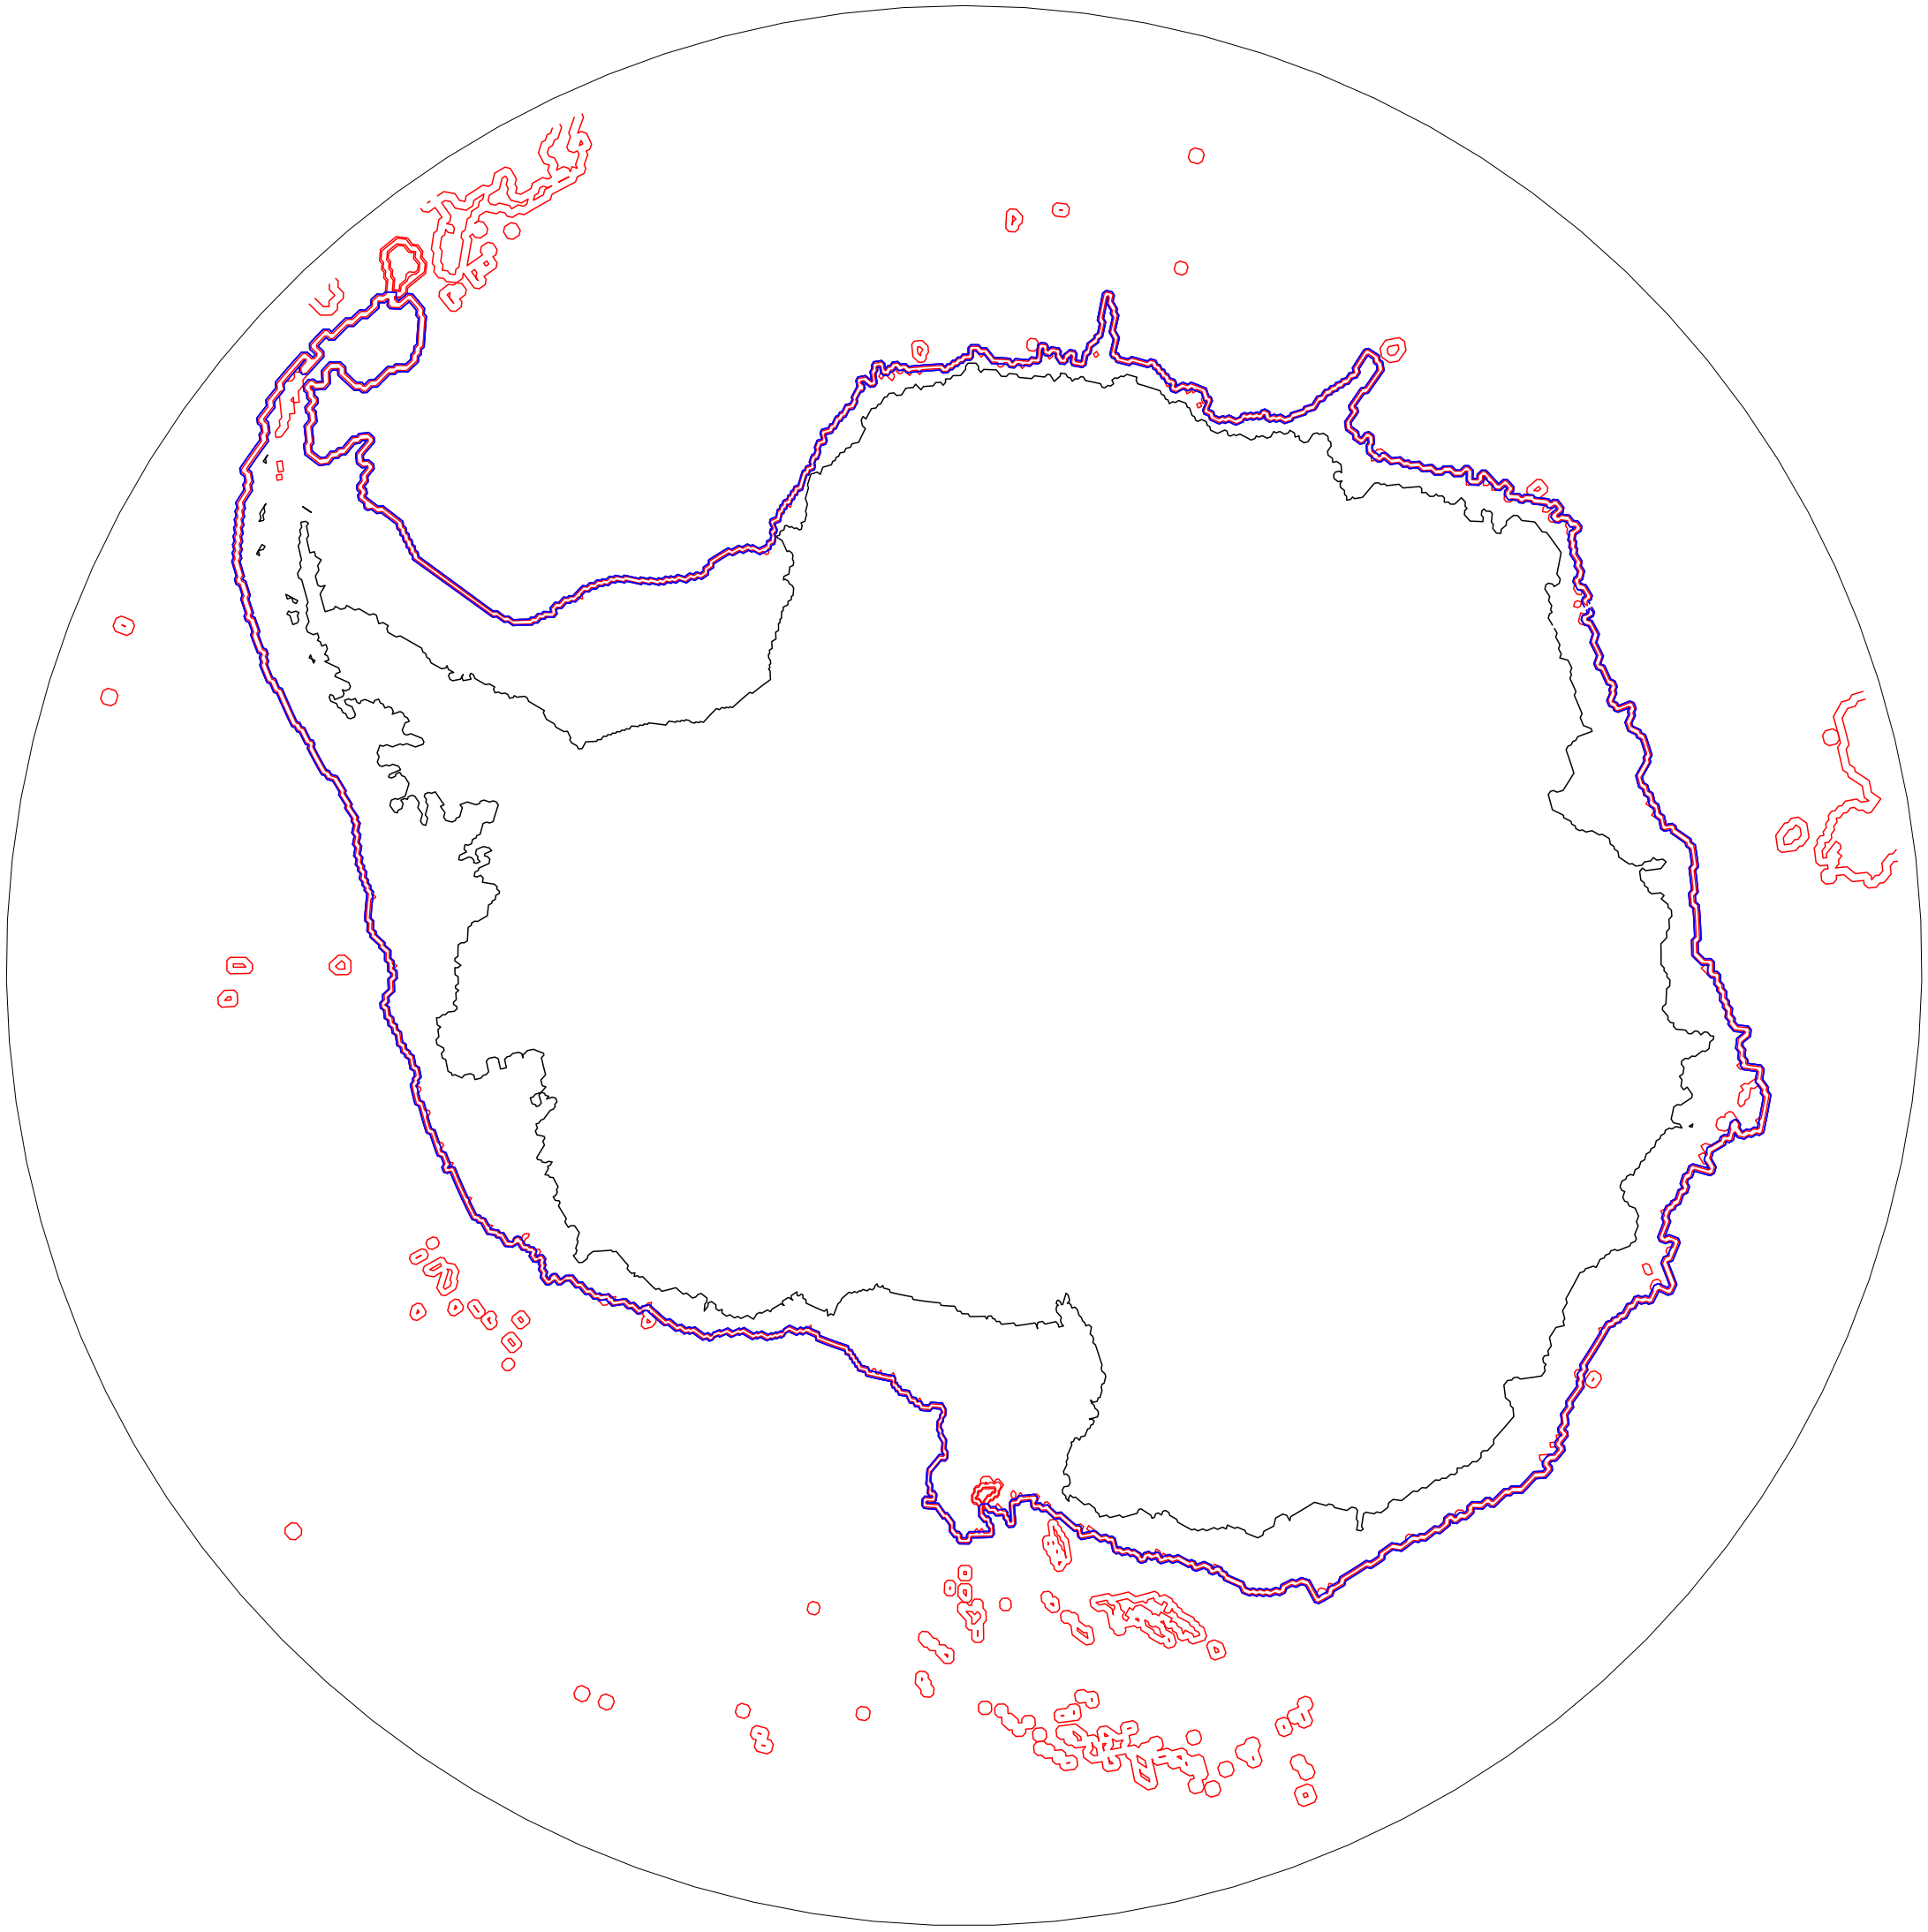

In [7]:
fig = plt.figure(figsize=[40, 40])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -58
so_basics(ax,land_mask,lat_north = -58, grid = False)
# basic contour - no attempt at isolating a continuous circumpolar feature
ax.contour(xh, yh,contour_mask0, levels = [0,1], colors = ['r'], alpha = 1, transform = ccrs.PlateCarree())
# circumpolar continuous isobath
ax.contour(xh, yh,contour_mask, levels = [0,1], colors = ['b'], alpha = 1, transform = ccrs.PlateCarree())

plt.show()

In [8]:
# save as xarray dataset
contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['yh', 'xh'])
contour_mask_numbered.attrs['description'] = '(OM4) Continous circumpolar approximation of the near Antarctic 2000 m isobath. Points on the isobath (tracer points) are numbered sequentially, providing an along-isobath index.'
contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['yh', 'xh'])
contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
contour_masked_south.attrs['description'] = '(OM4) Masks for the region south of a continous circumpolar approximation of the near Antarctic 2000 m isobath. Tracer points on and polewards of the isobath are 1, points equatorward of the isobath are nan.'
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yh,xh], dims = ['yh','xh'])
mask_y_transport.attrs['description'] = '(OM4) Informs which sign of v (meridional transport) is transport *into* the 2000 m isobath enclosed region. This mask is -1 where positive v denotes transport poleward across the isobath and +1 where positive v denotes tranport equatorward across the isobath. 0 where isobath not present, or cross isobath transport is zonal (see mask_x_transport). When using this mask, positive cross-isobath transports are offshore.'
mask_x_transport = xr.DataArray(mask_x_transport, coords = [yh,xh], dims = ['yh','xh'])
mask_x_transport.attrs['description'] = '(OM4) Informs which sign of u (zonal transport) is transport *into* the 2000 m isobath enclosed region. This mask is -1 where positive u denotes transport poleward across the isobath and +1 where positive u denotes tranport equatorward across the isobath. 0 where isobath not present, or cross isobath transport is meridional (see mask_y_transport). When using this mask, positive cross-isobath transports are offshore.'
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yh,xh], dims = ['yh','xh'])
mask_y_transport_numbered.attrs['description'] = '(OM4) as contour_mask_numbered, except only points on the isobath running east-west (for which cross-isobath transport is meridional transport) included.'
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yh,xh], dims = ['yh','xh'])
mask_x_transport_numbered.attrs['description'] = '(OM4) as contour_mask_numbered, except only points on the isobath running north-south (for which cross-isobath transport is zonal transport) included.'

In [9]:
ds = xr.Dataset({'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south, 'mask_y_transport':mask_y_transport,'mask_x_transport':mask_x_transport, 'mask_y_transport_numbered':mask_y_transport_numbered, 'mask_x_transport_numbered':mask_x_transport_numbered})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4_Antarctic_2000m_isobath.nc')

In [10]:
contour_mask_numbered_1D = contour_mask_numbered.stack(isobath_position = ['yh','xh'])
contour_mask_numbered_1D = contour_mask_numbered_1D.where(contour_mask_numbered_1D>0, drop = True)
isobath_index = contour_mask_numbered_1D.sortby(contour_mask_numbered_1D)
lat_along_isobath = isobath_index.yh
lon_along_isobath = isobath_index.xh

In [11]:
isobath_index

<xarray.DataArray (isobath_position: 2615)>
array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.613e+03, 2.614e+03,
       2.615e+03], dtype=float32)
Coordinates:
  * isobath_position  (isobath_position) MultiIndex
  - yh                (isobath_position) float64 -66.11 -66.11 ... -66.11 -66.11
  - xh                (isobath_position) float64 -299.7 -299.5 ... 59.78 60.03
Attributes:
    description:  (OM4) Continous circumpolar approximation of the near Antar...

In [12]:
lat_along_isobath = xr.DataArray(lat_along_isobath, coords = [isobath_index.values], dims = 'isobath_index')
lon_along_isobath = xr.DataArray(lon_along_isobath, coords = [isobath_index.values], dims = 'isobath_index')
isobath_index = xr.DataArray(isobath_index, coords = [isobath_index.values], dims = 'isobath_index')
isobath_index = xr.DataArray(isobath_index, coords = {'isobath_index':isobath_index, 'yh': lat_along_isobath, 'xh': lon_along_isobath} )
ds = xr.Dataset({'isobath_index':isobath_index})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4_Antarctic_2000m_isobath-index.nc')

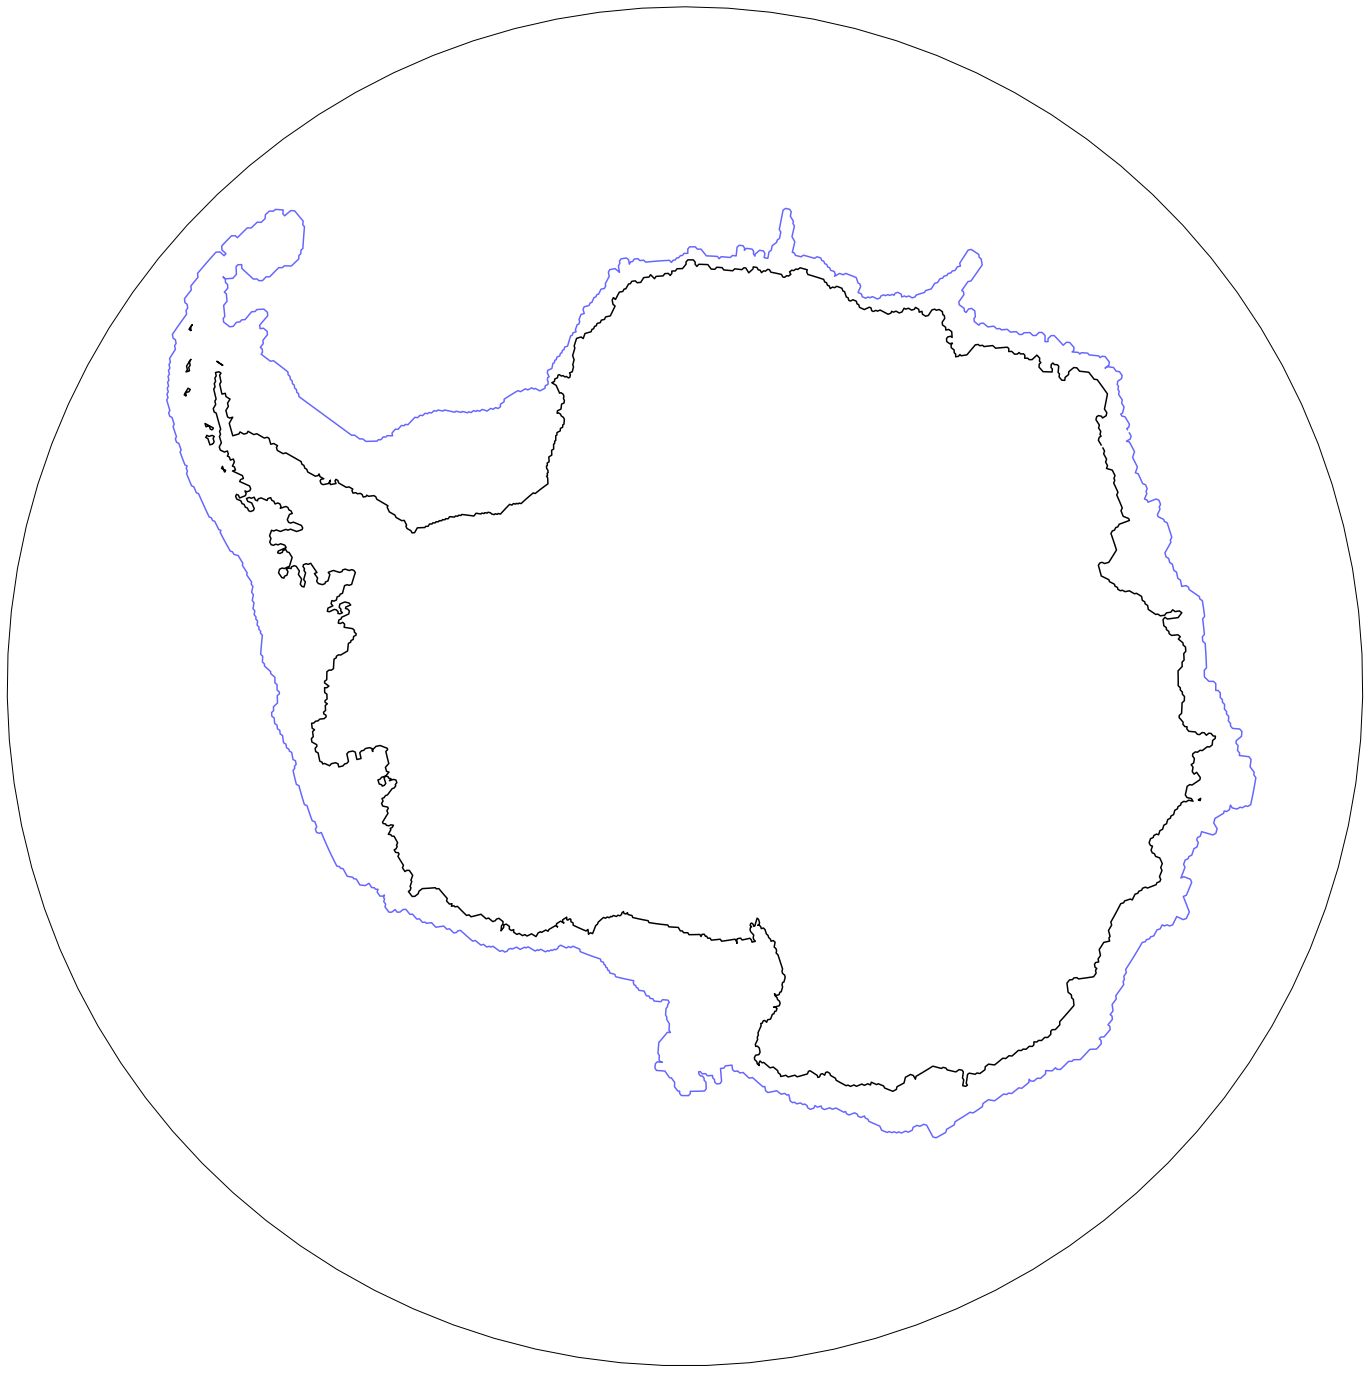

In [13]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -58
so_basics(ax,land_mask,lat_north = -58, grid = False)
ax.contour(contour_masked_south.sel(yh = slice(-90,lat_north)).xh, contour_masked_south.sel(yh = slice(-90,lat_north)).yh,contour_masked_south.sel(yh = slice(-90,lat_north)).fillna(0), levels = [0,1], colors = 'b', alpha = 0.6, transform = ccrs.PlateCarree())
# ax.contourf(contour_masked_south.sel(yh = slice(-90,lat_north)).xh, contour_masked_south.sel(yh = slice(-90,lat_north)).yh,contour_masked_south.sel(yh = slice(-90,lat_north)), levels = [0,1], colors = 'b', alpha = 0.6, transform = ccrs.PlateCarree())
plt.show()

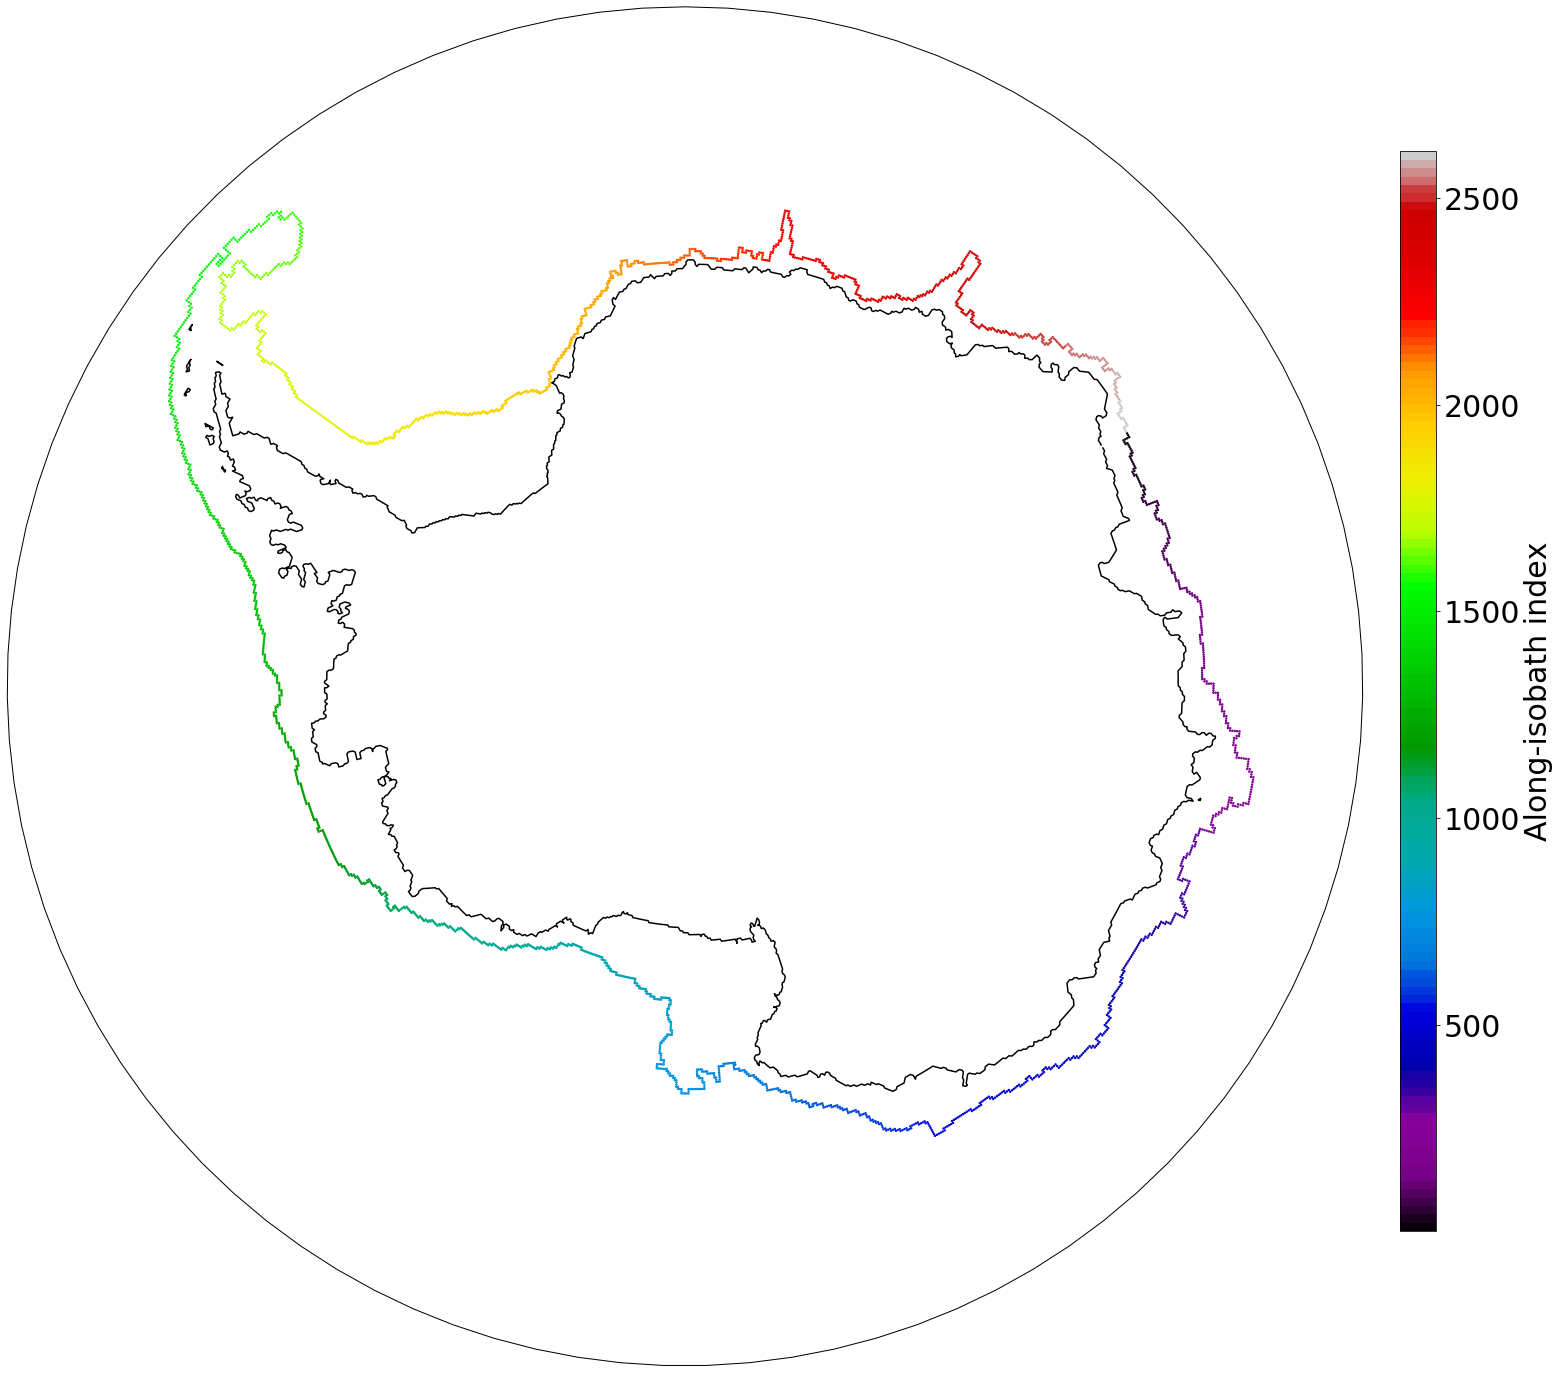

In [14]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -58
so_basics(ax,land_mask,lat_north = -58, grid = False)
# ax.contour(xh, yh,contour_mask, levels = [0,1], colors = ['k'], alpha = 0.5, transform = ccrs.PlateCarree())
plot = ax.scatter(lon_along_isobath, lat_along_isobath,c = isobath_index, cmap = nclcmaps.cmap('MPL_Spectral'), s = 2, transform = ccrs.PlateCarree())
cax = fig.add_axes([0.91, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Along-isobath index', fontsize = 30)
plt.show()

## Observed satellite period (1993-2017) mean ssh - most southerly circupolar continuous contour

In [15]:
# original, unaltered contour 
cmems_obs = xr.open_mfdataset('/work/Ruth.Moorman/CMEMS_SSH/dataset-duacs-rep-global-merged-allsat-phy-l4*.nc')
# these data are dailyabsolute dynamic topography (ssh above the geiod)
cmems_obs = cmems_obs.adt
# the model run only goes to 2017, so may as well remove the latest years
cmems_obs_mean = cmems_obs.sel(time = slice(None, '2017')).mean(dim = 'time')

In [16]:
cmems_obs

<xarray.DataArray 'adt' (time: 9629, latitude: 245, longitude: 1440)>
dask.array<concatenate, shape=(9629, 245, 1440), dtype=float64, chunksize=(731, 245, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... -29.125 -28.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-05-13
Attributes:
    comment:        The absolute dynamic topography is the sea surface height...
    grid_mapping:   crs
    long_name:      Absolute dynamic topography
    standard_name:  sea_surface_height_above_geoid
    units:          m
    _ChunkSizes:    [ 1 50 50]

In [17]:
cmems_obs_mean = cmems_obs_mean.load()

In [18]:
temp = cmems_obs_mean.where(cmems_obs_mean<=-1.063) * 0 + 1

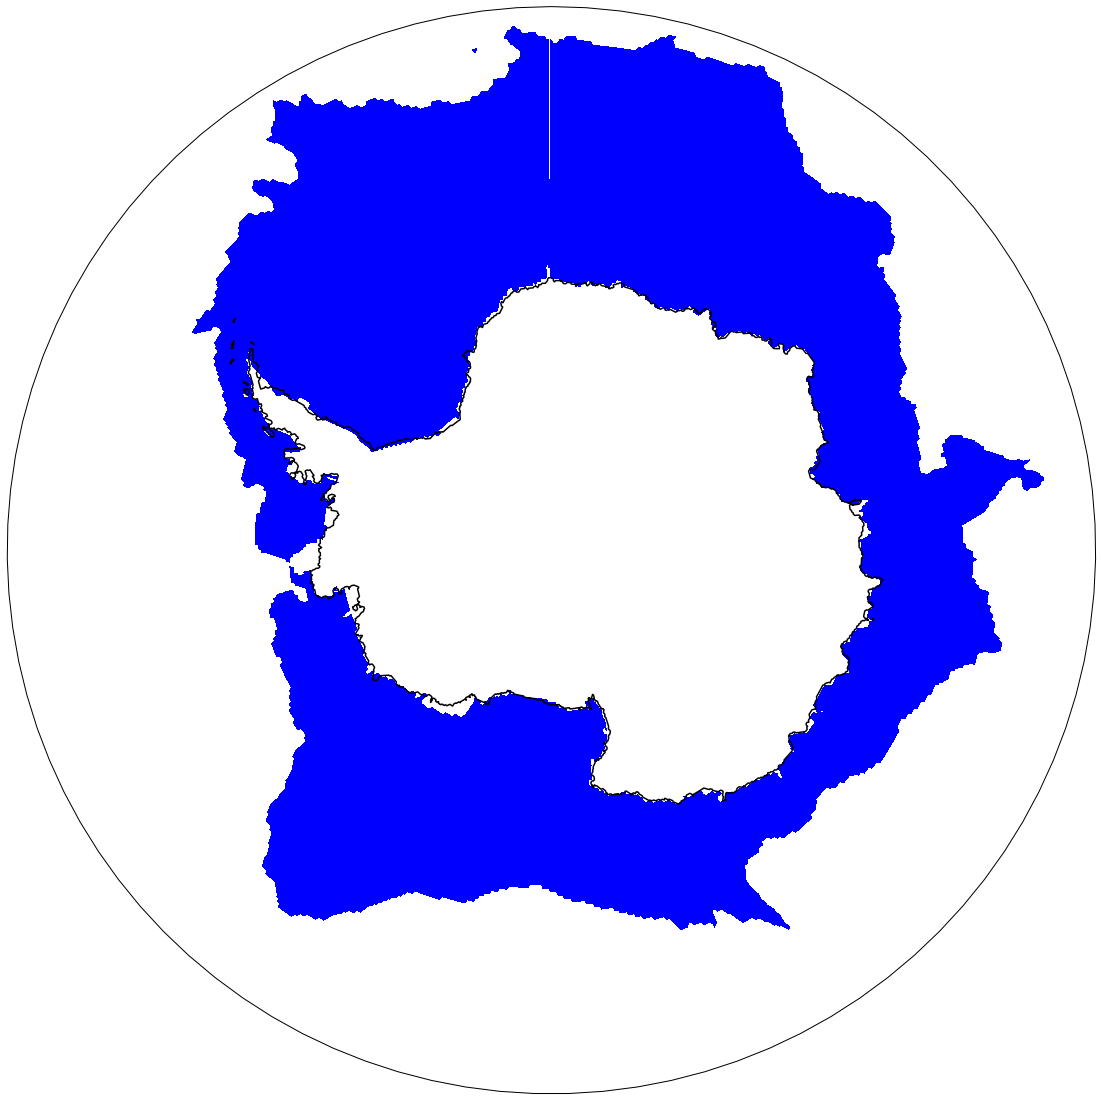

In [19]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
ax.contourf(temp.longitude, temp.latitude,temp, levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())
plt.show()

In [20]:
# looks kind of discontinuous, but it's not:
print(temp.sum(dim = 'latitude').min().values) # would be zero if that gap in wa was not an artifact of plotting

1.0


In [21]:
cmems_obs_mean

<xarray.DataArray 'adt' (latitude: 245, longitude: 1440)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.50684555, 0.50546349, 0.50474405, ..., 0.51454928, 0.51176766,
        0.50908757],
       [0.49660954, 0.49599677, 0.49623698, ..., 0.50387174, 0.50112901,
        0.49848241],
       [0.48870534, 0.48893278, 0.49010419, ..., 0.49508306, 0.49241255,
        0.48997378]])
Coordinates:
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... -29.125 -28.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [22]:
contour_depth = -1.063
lat_north = -29
# initial basic masking
temp_mask = cmems_obs_mean.copy().fillna(1)
longitude = temp_mask.longitude
latitude = temp_mask.latitude
temp_mask = temp_mask.where(temp_mask <= contour_depth) * 0 + 1
temp_mask = temp_mask.fillna(0)
temp_mask = temp_mask.values # extract numpy file
# # this spreads the isobath contour so all points are connected adjacently (not just 
# # diagonally):
kernel = np.ones((3,3),np.uint8)
contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
# start at western edge of domain, at y point closest to correct depth contour:
contour_mask = np.zeros_like(temp_mask) 
contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
contour_mask[contour_lat_index_start,0] = 1
# loop through to find adjacent point closest to contour depth (not inc previous point):
last_index_i = 0
last_index_j = contour_lat_index_start
count = 0
while last_index_i<(len(longitude)-1): # 1440 is xh dimension length
	# first time don't go backwards:
	if last_index_i == 0:
		points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
			0,
			contour_mask0[last_index_j+1,last_index_i],
			contour_mask0[last_index_j-1,last_index_i]])
	else:
		points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
			contour_mask0[last_index_j,last_index_i-1],
			contour_mask0[last_index_j+1,last_index_i],
			contour_mask0[last_index_j-1,last_index_i]])
	new_loc = np.where(points_to_compare==1)[0]
	# this gives each point along contour a unique index number:
	if len(new_loc)==0:
		contour_mask[last_index_j,last_index_i] = 0
		contour_mask0[last_index_j,last_index_i] = 0
		#contour_mask0[contour_mask==count] = 0
		#print('j'+str(last_index_j)+'i'+str(last_index_i))
		count = count - 1
		last_index_i = np.where(contour_mask==count+1)[1]
		last_index_j = np.where(contour_mask==count+1)[0]
		continue
	elif len(new_loc)>0:
		if new_loc[0] == 0:
			new_index_i = last_index_i+1
			new_index_j = last_index_j
		elif new_loc[0] == 1:
			new_index_i = last_index_i-1
			new_index_j = last_index_j
		elif new_loc[0] == 2:
			new_index_i = last_index_i
			new_index_j = last_index_j+1
		elif new_loc[0] == 3:
			new_index_i = last_index_i
			new_index_j = last_index_j-1
		contour_mask[new_index_j,new_index_i] = count + 2
		contour_mask0[last_index_j,last_index_i] = 2
		last_index_j = new_index_j
		last_index_i = new_index_i
		count += 1
# # this is the sequentially numbered isobath, it provides an along isobath index
contour_mask_numbered = contour_mask
# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1,0] = -100
# from top left:
for ii in range(len(longitude)-1):
	for jj in range(len(latitude))[::-1][:-1]:
		if contour_masked_above[jj,ii] == -100:
			if contour_masked_above[jj-1,ii] == 0:
				contour_masked_above[jj-1,ii] = -100
			if contour_masked_above[jj,ii+1] == 0:
				contour_masked_above[jj,ii+1] = -100
			if contour_masked_above[jj-1,ii+1] == 0:
				contour_masked_above[jj-1,ii+1] = -100
# from top right:
for ii in range(len(longitude))[::-1][:-1]:
	for jj in range(len(latitude))[::-1][:-1]:
		if contour_masked_above[jj,ii] == -100:
			if contour_masked_above[jj-1,ii] == 0:
				contour_masked_above[jj-1,ii] = -100
			if contour_masked_above[jj,ii-1] == 0:
				contour_masked_above[jj,ii-1] = -100
			if contour_masked_above[jj-1,ii-1] == 0:
				contour_masked_above[jj-1,ii-1] = -100
# from bottom right:
for ii in range(len(longitude))[::-1][:-1]:
	for jj in range(len(latitude)-1):
		if contour_masked_above[jj,ii] == -100:
			if contour_masked_above[jj+1,ii] == 0:
				contour_masked_above[jj+1,ii] = -100
			if contour_masked_above[jj,ii-1] == 0:
				contour_masked_above[jj,ii-1] = -100
			if contour_masked_above[jj+1,ii-1] == 0:
				contour_masked_above[jj+1,ii-1] = -100
# from bottom left:
for ii in range(len(longitude)-1):
	for jj in range(len(latitude)-1):
		if contour_masked_above[jj,ii] == -100:
			if contour_masked_above[jj+1,ii] == 0:
				contour_masked_above[jj+1,ii] = -100
			if contour_masked_above[jj,ii+1] == 0:
				contour_masked_above[jj,ii+1] = -100
			if contour_masked_above[jj+1,ii+1] == 0:
				contour_masked_above[jj+1,ii+1] = -100
############################
# separate out points on isobath that will correspond to zonal or meridional transport
# across contour (i.e. depending on localshape of contour):
# NO POINT FOR THIS CONTOUR, NO MODEL DATA ON THIS LAT LON GRID ANYWAY (mostly need the isobath index variable and mask)

In [23]:
# save as xarray dataset
contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [latitude, longitude], dims = ['latitude', 'longitude'])
contour_mask_numbered.attrs['description'] = '(CMEMS) Southernmost continous circumpolar ssh contour (value -1.603m) in the 1993-2017 time mean CMEMS ADT satellite dataset. Points on the contour are numbered sequentially, providing an along-contour index.'
contour_masked_south = xr.DataArray(contour_masked_above, coords = [latitude, longitude], dims = ['latitude', 'longitude'])
contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
contour_masked_south.attrs['description'] = '(CMEMS) Masks for the region south of the southernmost continous circumpolar ssh contour (value -1.603m) in the 1993-2017 time mean CMEMS ADT satellite dataset. Gridpoints on and polewards of the contour are 1, points equatorward of the contour are nan.'

In [24]:
ds = xr.Dataset({'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/CMEMS_1993-2017_mean_ssh_southernmost_contour.nc')

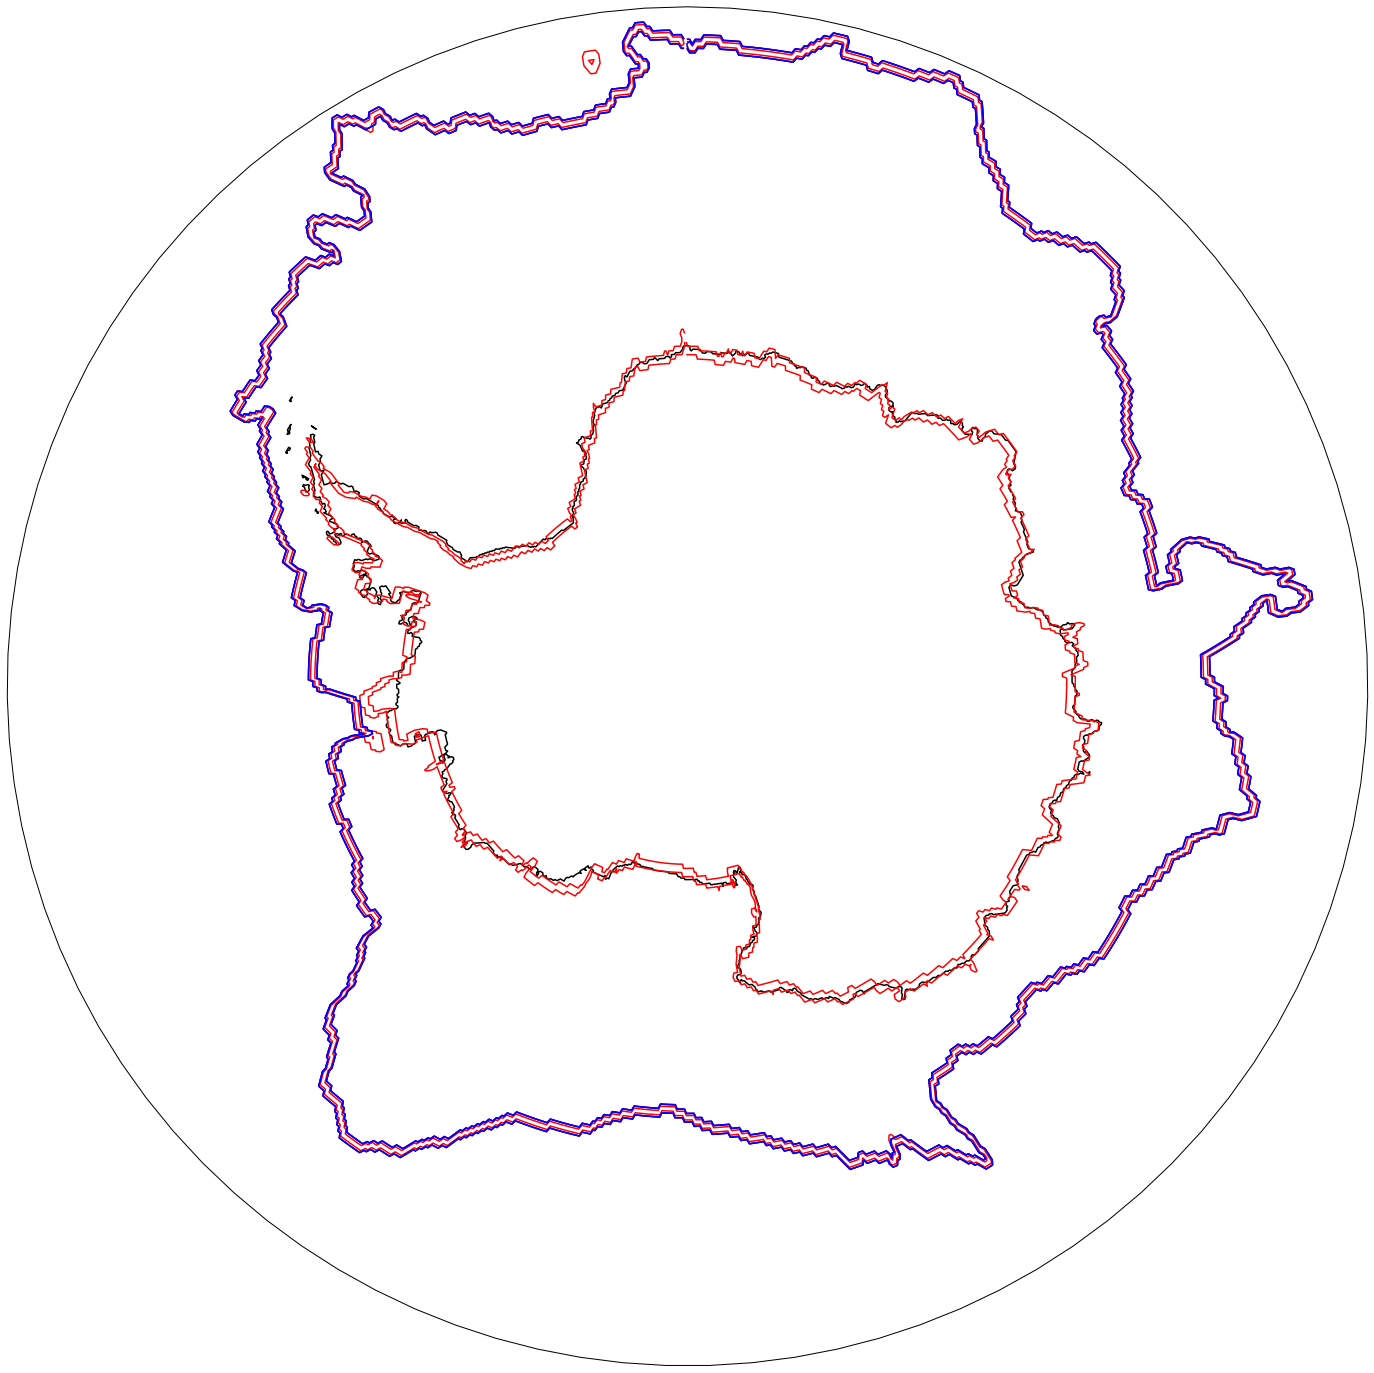

In [25]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
# basic contour - no attempt at isolating a continuous circumpolar feature
ax.contour(longitude, latitude,contour_mask0, levels = [0,1], colors = ['r'], alpha = 1, transform = ccrs.PlateCarree())
# circumpolar continuous isobath
ax.contour(longitude, latitude,contour_mask, levels = [0,1], colors = ['b'], alpha = 1, transform = ccrs.PlateCarree())
plt.show()

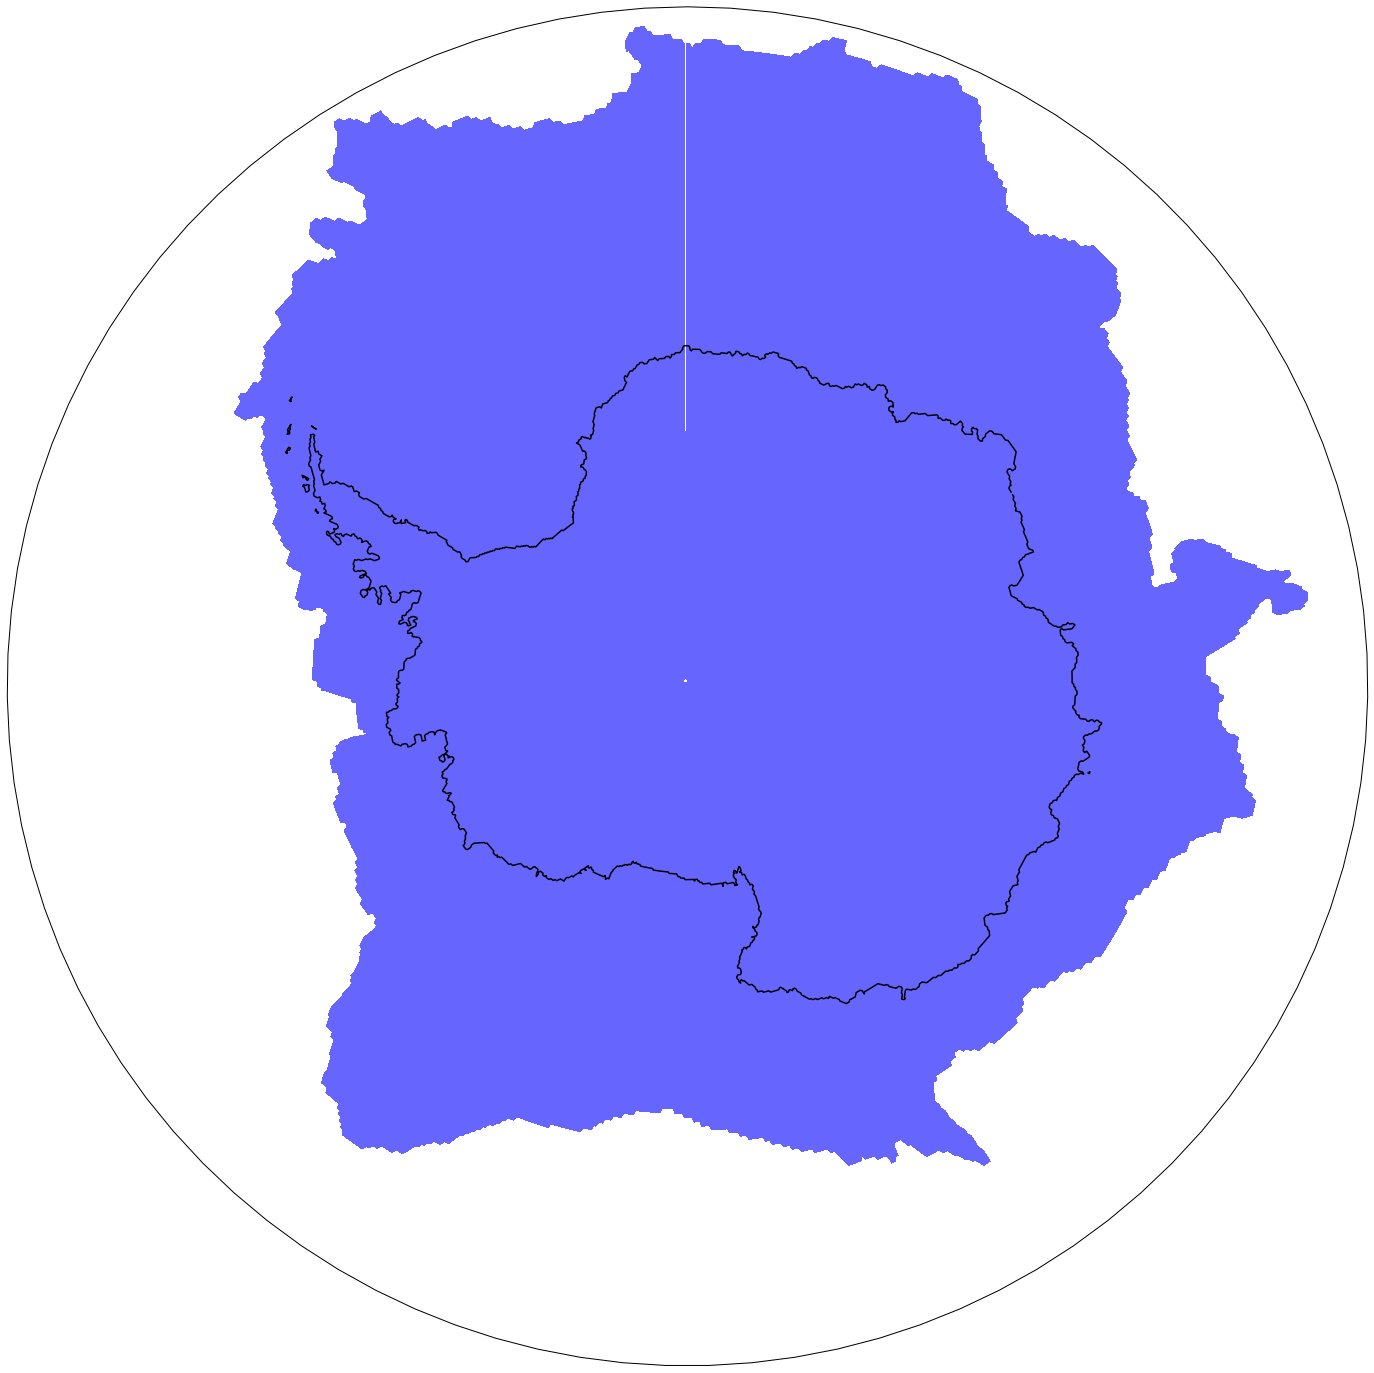

In [26]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
# ax.contour(contour_masked_south.sel(latitude = slice(-90,lat_north)).longitude, contour_masked_south.sel(latitude = slice(-90,lat_north)).latitude,contour_masked_south.sel(latitude = slice(-90,lat_north)).fillna(0), levels = [0,1], colors = 'b', alpha = 0.6, transform = ccrs.PlateCarree())
ax.contourf(contour_masked_south.sel(latitude = slice(-90,lat_north)).longitude, contour_masked_south.sel(latitude = slice(-90,lat_north)).latitude,contour_masked_south.sel(latitude = slice(-90,lat_north)), levels = [0,1], colors = 'b', alpha = 0.6, transform = ccrs.PlateCarree())
plt.show()

In [27]:
contour_mask_numbered_1D = contour_mask_numbered.stack(contour_position = ['latitude','longitude'])
contour_mask_numbered_1D = contour_mask_numbered_1D.where(contour_mask_numbered_1D>0, drop = True)
contour_index = contour_mask_numbered_1D.sortby(contour_mask_numbered_1D)
lat_along_contour = contour_index.latitude
lon_along_contour = contour_index.longitude

In [28]:
contour_index

<xarray.DataArray (contour_position: 2090)>
array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.088e+03, 2.089e+03,
       2.090e+03])
Coordinates:
  * contour_position  (contour_position) MultiIndex
  - latitude          (contour_position) float64 -52.62 -52.62 ... -52.62 -52.62
  - longitude         (contour_position) float64 0.125 0.375 ... 359.6 359.9
Attributes:
    description:  (CMEMS) Southernmost continous circumpolar ssh contour (val...

In [29]:
lat_along_contour = xr.DataArray(lat_along_contour, coords = [contour_index.values], dims = 'contour_index')
lon_along_contour = xr.DataArray(lon_along_contour, coords = [contour_index.values], dims = 'contour_index')
contour_index = xr.DataArray(contour_index, coords = [contour_index.values], dims = 'contour_index')
contour_index = xr.DataArray(contour_index, coords = {'contour_index':contour_index, 'latitude': lat_along_contour, 'longitude': lon_along_contour} )
ds = xr.Dataset({'contour_index':contour_index})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/CMEMS_1993-2017_mean_ssh_southernmost_contour-index.nc')

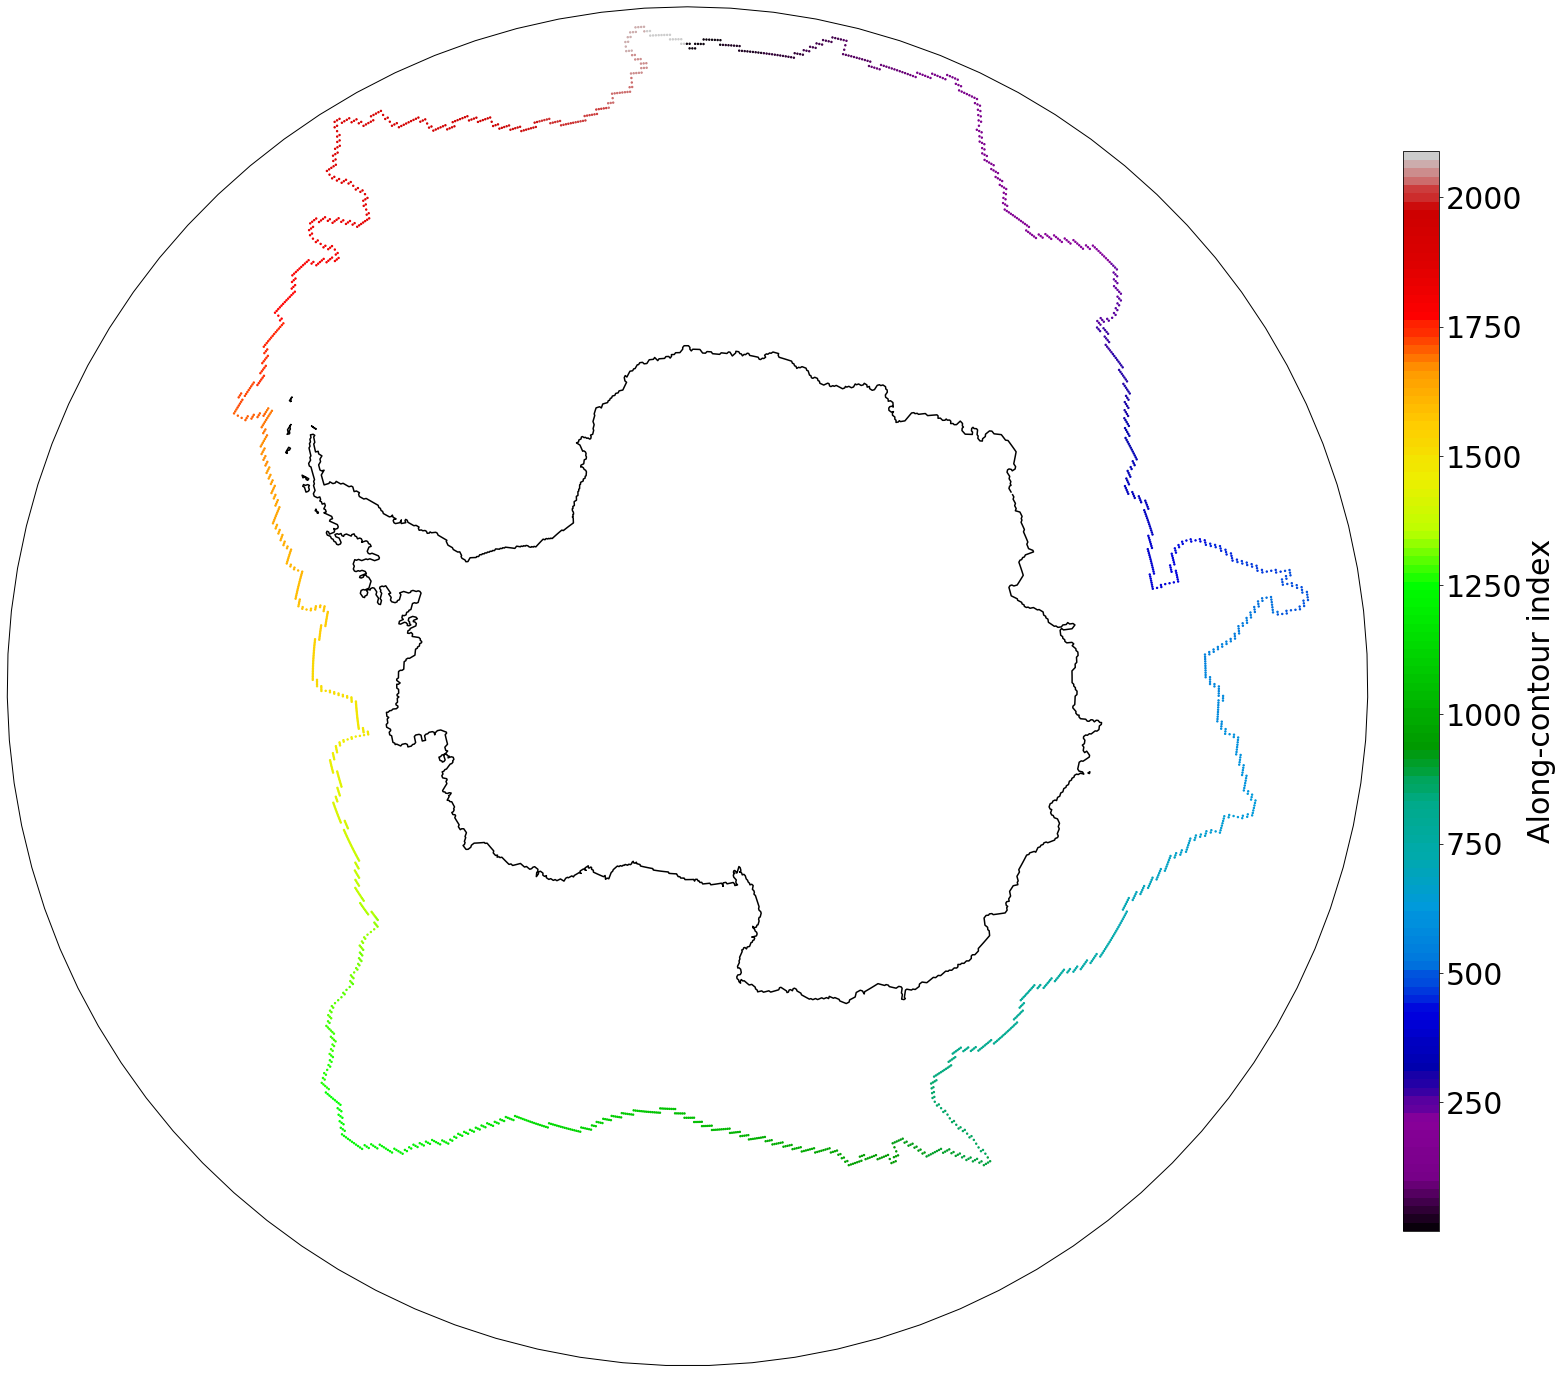

In [30]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
# ax.contour(xh, yh,contour_mask, levels = [0,1], colors = ['k'], alpha = 0.5, transform = ccrs.PlateCarree())
plot = ax.scatter(lon_along_contour, lat_along_contour,c = contour_index, cmap = nclcmaps.cmap('MPL_Spectral'), s = 2, transform = ccrs.PlateCarree())
cax = fig.add_axes([0.91, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Along-contour index', fontsize = 30)
plt.show()

## Function: find the southernmost circumpolar continuous isobath in OM4p25 output

Now...really the ideal would be to use this sort of procedure to *identify* the ssh value corresponding to the southernmest circumpolar continuous ssh contour (not the laborious mannual identificant I tried initially). Let's have a go at developing such a method.

### This function is now saved to om4_tools.py

In [19]:
# start with the cycle1 OM4p25 BLING run, need ssh and (I suspect) land masking
# will work with the 1993-2017 mean ssh field (satellite era)
om4 = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/'
ssh_annual = get_iaf_variable(om4,1, 'ocean_annual', 'zos')
static = xr.open_dataset(om4+'/cycle1/ocean_static/20170101.ocean_static.nc')
lat_north = -29
land_mask = static.wet.sel(yh = slice(-90,lat_north))

In [20]:
ssh = ssh_annual.sel(time = slice('1993', '2017')).mean(dim = 'time')

In [21]:
ssh = ssh.load()

In [22]:
def southernmost_continuous_ssh_contour(ssh, range_tested, lat_north):
    """
    Script to find the southernmost circumpolar continuous ssh contour from OM4 output.
    Will test each contour value in range_tested, terminating at the first value of range_tested for which a circumpolar continuous contour may be constructed.
    As such, the input range_tested must be intelligently defined such that the first values tested refer to the value fo the field very close to the Antarctic coast.
    As we move through range_tested, the value of range_tested should be ound in the field further and further away from the coast.
    For example, the script was designed with a mind to find the southernmost continuous ssh contour, and in this case a range_tested ranging from strongly negative values upward should work (e.g. np.arange(-1.7,-1.4,0.001)).
    Prints the field value that produces the southermost circumpolar contour. (if nothing printed or printed value is first valu ein range_tested, alter range_tested)
    
    returns contour_mask_numbered, contour_masked_south, contour_index
    
    contour_mask_numbered (xarray) = 0 off the contour, nonzero on the contour. Points on the contour are numbered seuqentially.
    contour_mask_south (xarray) = Gridpoints on and polewards of the contour are 1, points equatorward of the contour are nan.
    contour_index (xarray) = lat and lon positions of each numbered point on the contour. An along-contour index.
    
    Ruth Moorman, Princeton University, May 2020
    """
    for contour_depth in range_tested:
        # initial basic masking
        temp = ssh.where(ssh<=contour_depth) * 0 + 1
        temp_mask = ssh.copy().fillna(1)
        xh = temp_mask.xh
        yh = temp_mask.yh
        temp_mask = temp_mask.where(temp_mask <= contour_depth) * 0 + 1
        temp_mask = temp_mask.fillna(0)
        temp_mask = temp_mask.values # extract numpy file
        # # this spreads the isobath contour so all points are connected adjacently (not just 
        # # diagonally):
        kernel = np.ones((3,3),np.uint8)
        contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
        # start at western edge of domain, at y point closest to correct depth contour:
        contour_mask = np.zeros_like(temp_mask) 
        contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
        contour_mask[contour_lat_index_start,0] = 1
        # loop through to find adjacent point closest to contour depth (not inc previous point):
        last_index_i = np.array([0])
        last_index_j = contour_lat_index_start
        count = 0
        while last_index_i<(len(xh)-1):
            # first time don't go backwards:
            if last_index_i == 0:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    0,
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            else:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    contour_mask0[last_index_j,last_index_i-1],
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            new_loc = np.where(points_to_compare==1)[0]
            # this gives each point along contour a unique index number:
            if len(new_loc)==0:
                contour_mask0[last_index_j,last_index_i] = 0
                count = count - 1
                last_index_i = np.where(contour_mask==count+1)[1]
                last_index_j = np.where(contour_mask==count+1)[0]
                if len(last_index_i) != 1:
#                     print('No circumpolar continuous contour at ssh = ',contour_depth)
                    break
                else:
                    continue
            elif len(new_loc)>0:
                if new_loc[0] == 0:
                    new_index_i = last_index_i+1
                    new_index_j = last_index_j
                elif new_loc[0] == 1:
                    new_index_i = last_index_i-1
                    new_index_j = last_index_j
                elif new_loc[0] == 2:
                    new_index_i = last_index_i
                    new_index_j = last_index_j+1
                elif new_loc[0] == 3:
                    new_index_i = last_index_i
                    new_index_j = last_index_j-1
                contour_mask[new_index_j,new_index_i] = count + 2
                contour_mask0[last_index_j,last_index_i] = 2
                last_index_j = new_index_j
                last_index_i = new_index_i
                count += 1
                if len(last_index_i) != 1:
#                     print('No circumpolar continuous contour')
                    break
        if np.sum(contour_mask, axis = 0).min() == 1:
            print('Southernmost circumpolar continuous profile at ssh = ', contour_depth)
            break
    # # this is the sequentially numbered isobath, it provides an along isobath index
    contour_mask_numbered = contour_mask
    # sometimes there's a discontinuoity at 0
    if last_index_j > contour_lat_index_start:
        a = 0
        for m in np.arange(last_index_j,contour_lat_index_start-1, -1):
            contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1] +a
            a += 1
    elif last_index_j < contour_lat_index_start:
        a = 0
        for m in np.arange(last_index_j, contour_lat_index_start+1, 1):
            contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1].values +a
            a += 1
    # fill in points to north of contour:
    contour_masked_above = np.copy(contour_mask_numbered)
    contour_masked_above[-1,0] = -100

    # from top left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj-1,ii+1] == 0:
                    contour_masked_above[jj-1,ii+1] = -100
    # from top right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj-1,ii-1] == 0:
                    contour_masked_above[jj-1,ii-1] = -100
    # from bottom right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj+1,ii-1] == 0:
                    contour_masked_above[jj+1,ii-1] = -100
    # from bottom left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj+1,ii+1] == 0:
                    contour_masked_above[jj+1,ii+1] = -100
    contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['yh', 'xh'])
    contour_mask_numbered.attrs['description'] = 'Southernmost continous circumpolar ssh contour (value '+str(contour_depth)[:6]+'m). Points on the contour are numbered sequentially, providing an along-contour index.'
    contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['yh', 'xh'])
    contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
    contour_masked_south.attrs['description'] = 'Masks for the region south of the southernmost continous circumpolar ssh contour (value '+str(contour_depth)[:6]+'m). Gridpoints on and polewards of the contour are 1, points equatorward of the contour are nan.'
    
    contour_mask_numbered_1D = contour_mask_numbered.stack(contour_position = ['yh','xh'])
    contour_mask_numbered_1D = contour_mask_numbered_1D.where(contour_mask_numbered_1D>0, drop = True)
    contour_index = contour_mask_numbered_1D.sortby(contour_mask_numbered_1D)
    lat_along_contour = xr.DataArray(contour_index.yh, coords = [contour_index.values], dims = 'contour_index')
    lon_along_contour = xr.DataArray(contour_index.xh, coords = [contour_index.values], dims = 'contour_index')
    contour_index = xr.DataArray(contour_index, coords = [contour_index.values], dims = 'contour_index')
    contour_index = xr.DataArray(contour_index, coords = {'contour_index':contour_index, 'yh': lat_along_contour, 'xh': lon_along_contour} )

    return contour_mask_numbered, contour_masked_south, contour_index

In [23]:
contour_mask_numbered, contour_masked_south, contour_index = southernmost_continuous_ssh_contour(ssh, np.arange(-1.68,-1.5,0.001), lat_north=-29)

Southernmost circumpolar continuous profile at ssh =  -1.6110000000000075


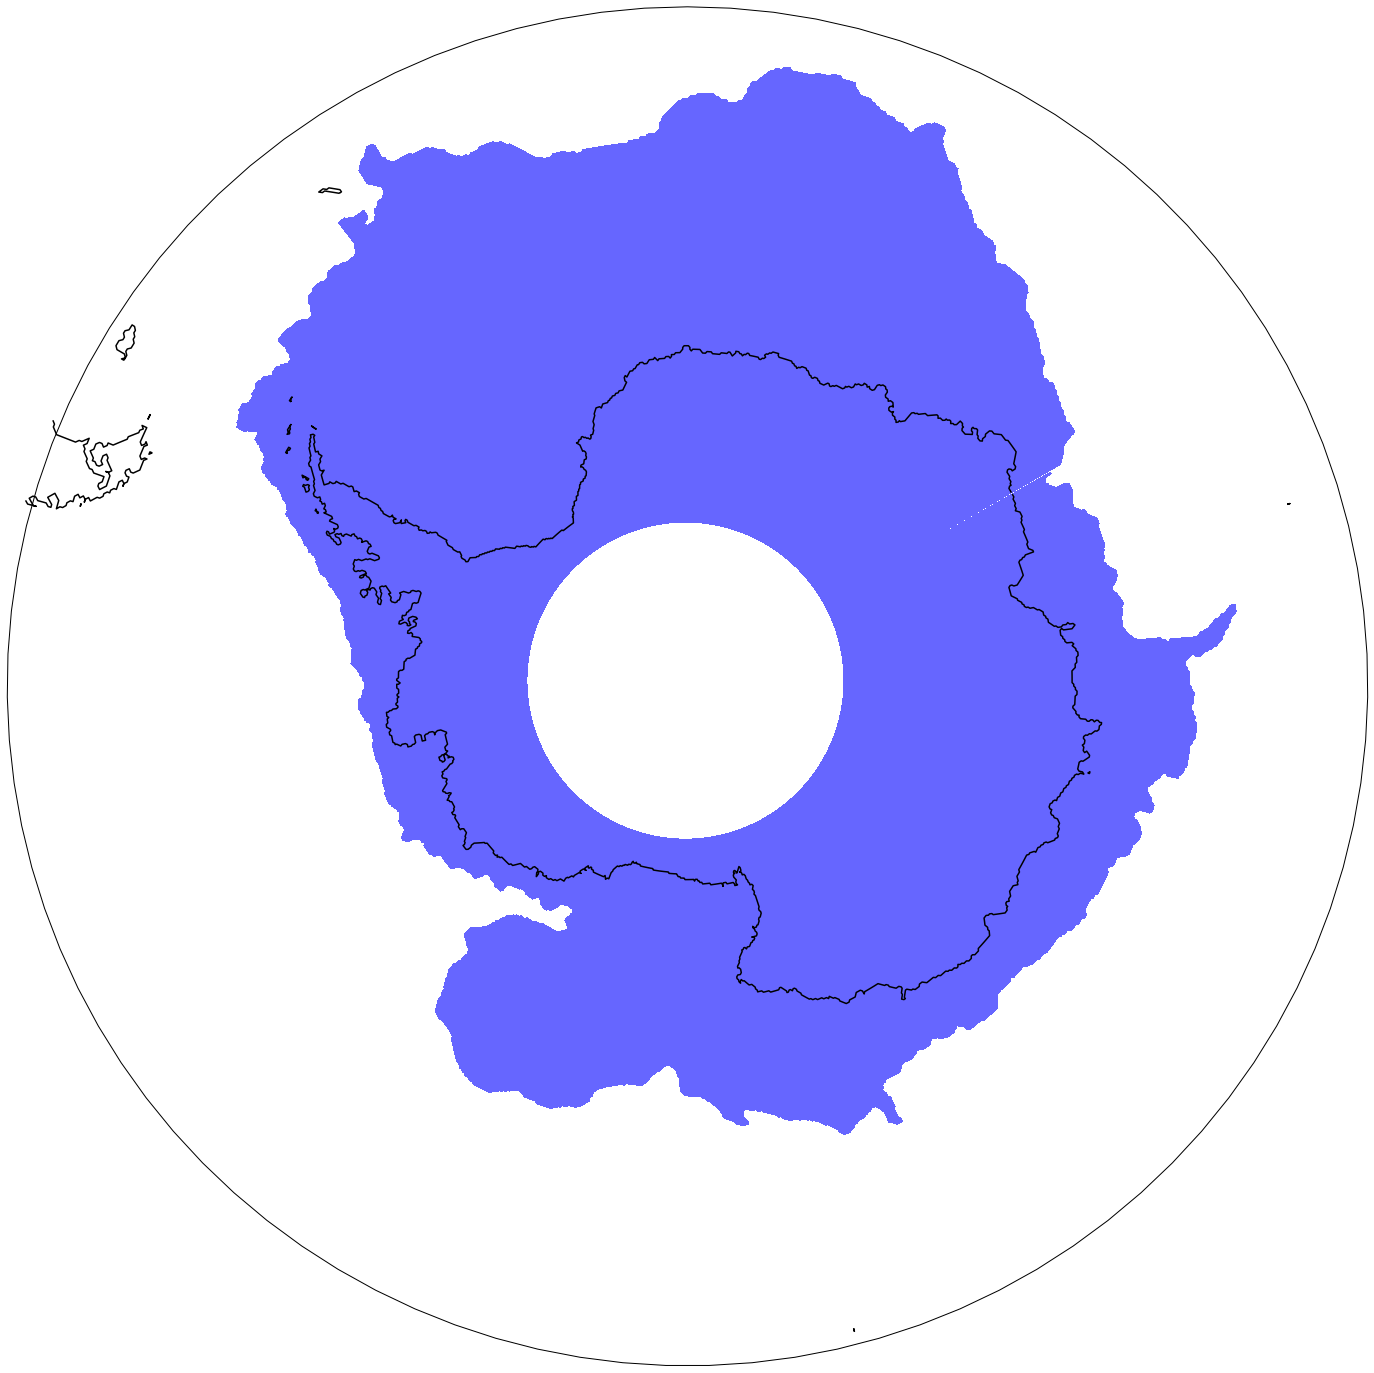

In [24]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
# ax.contour(contour_masked_south.sel(latitude = slice(-90,lat_north)).longitude, contour_masked_south.sel(latitude = slice(-90,lat_north)).latitude,contour_masked_south.sel(latitude = slice(-90,lat_north)).fillna(0), levels = [0,1], colors = 'b', alpha = 0.6, transform = ccrs.PlateCarree())
ax.contourf(contour_masked_south.sel(yh = slice(-90,lat_north)).xh, contour_masked_south.sel(yh = slice(-90,lat_north)).yh,contour_masked_south.sel(yh = slice(-90,lat_north)), levels = [0,1], colors = 'b', alpha = 0.6, transform = ccrs.PlateCarree())
plt.show()

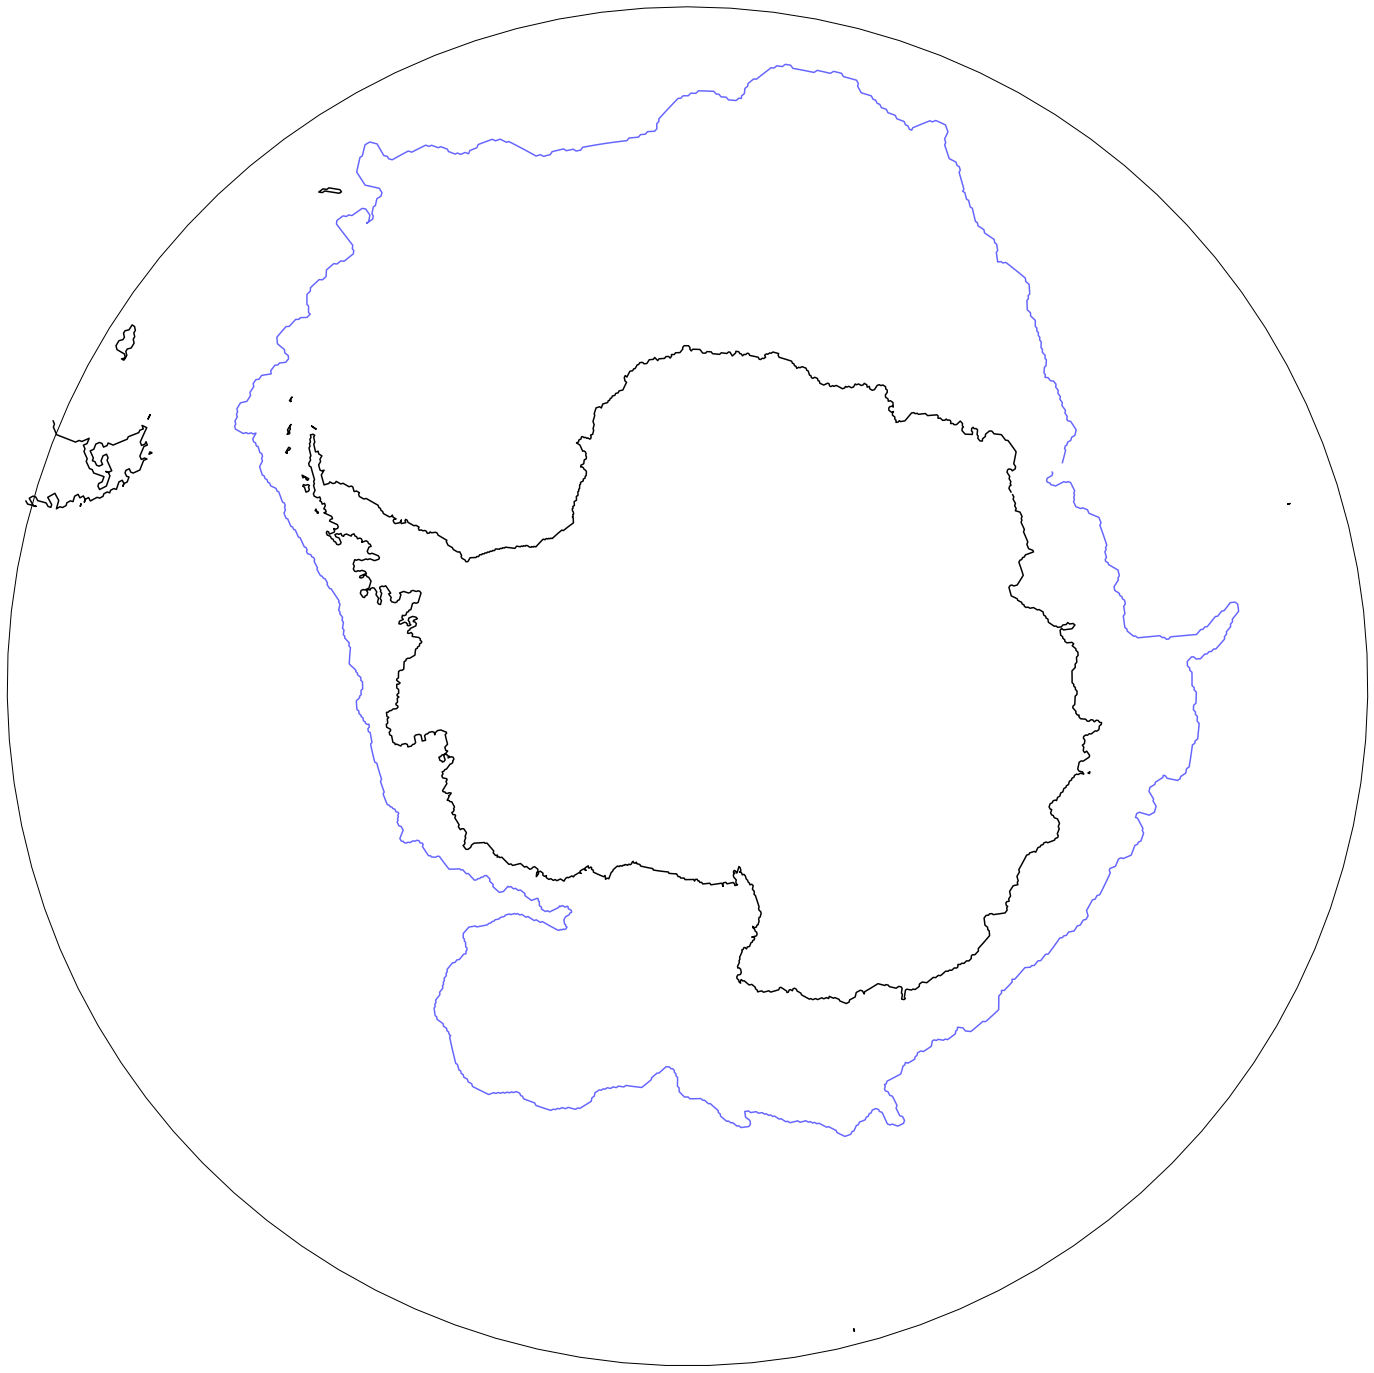

In [25]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
ax.contour(contour_masked_south.sel(yh = slice(-90,lat_north)).xh, contour_masked_south.sel(yh = slice(-90,lat_north)).yh,contour_masked_south.sel(yh = slice(-90,lat_north)).fillna(0), levels = [0,1], colors = 'b', alpha = 0.6, transform = ccrs.PlateCarree())
plt.show()

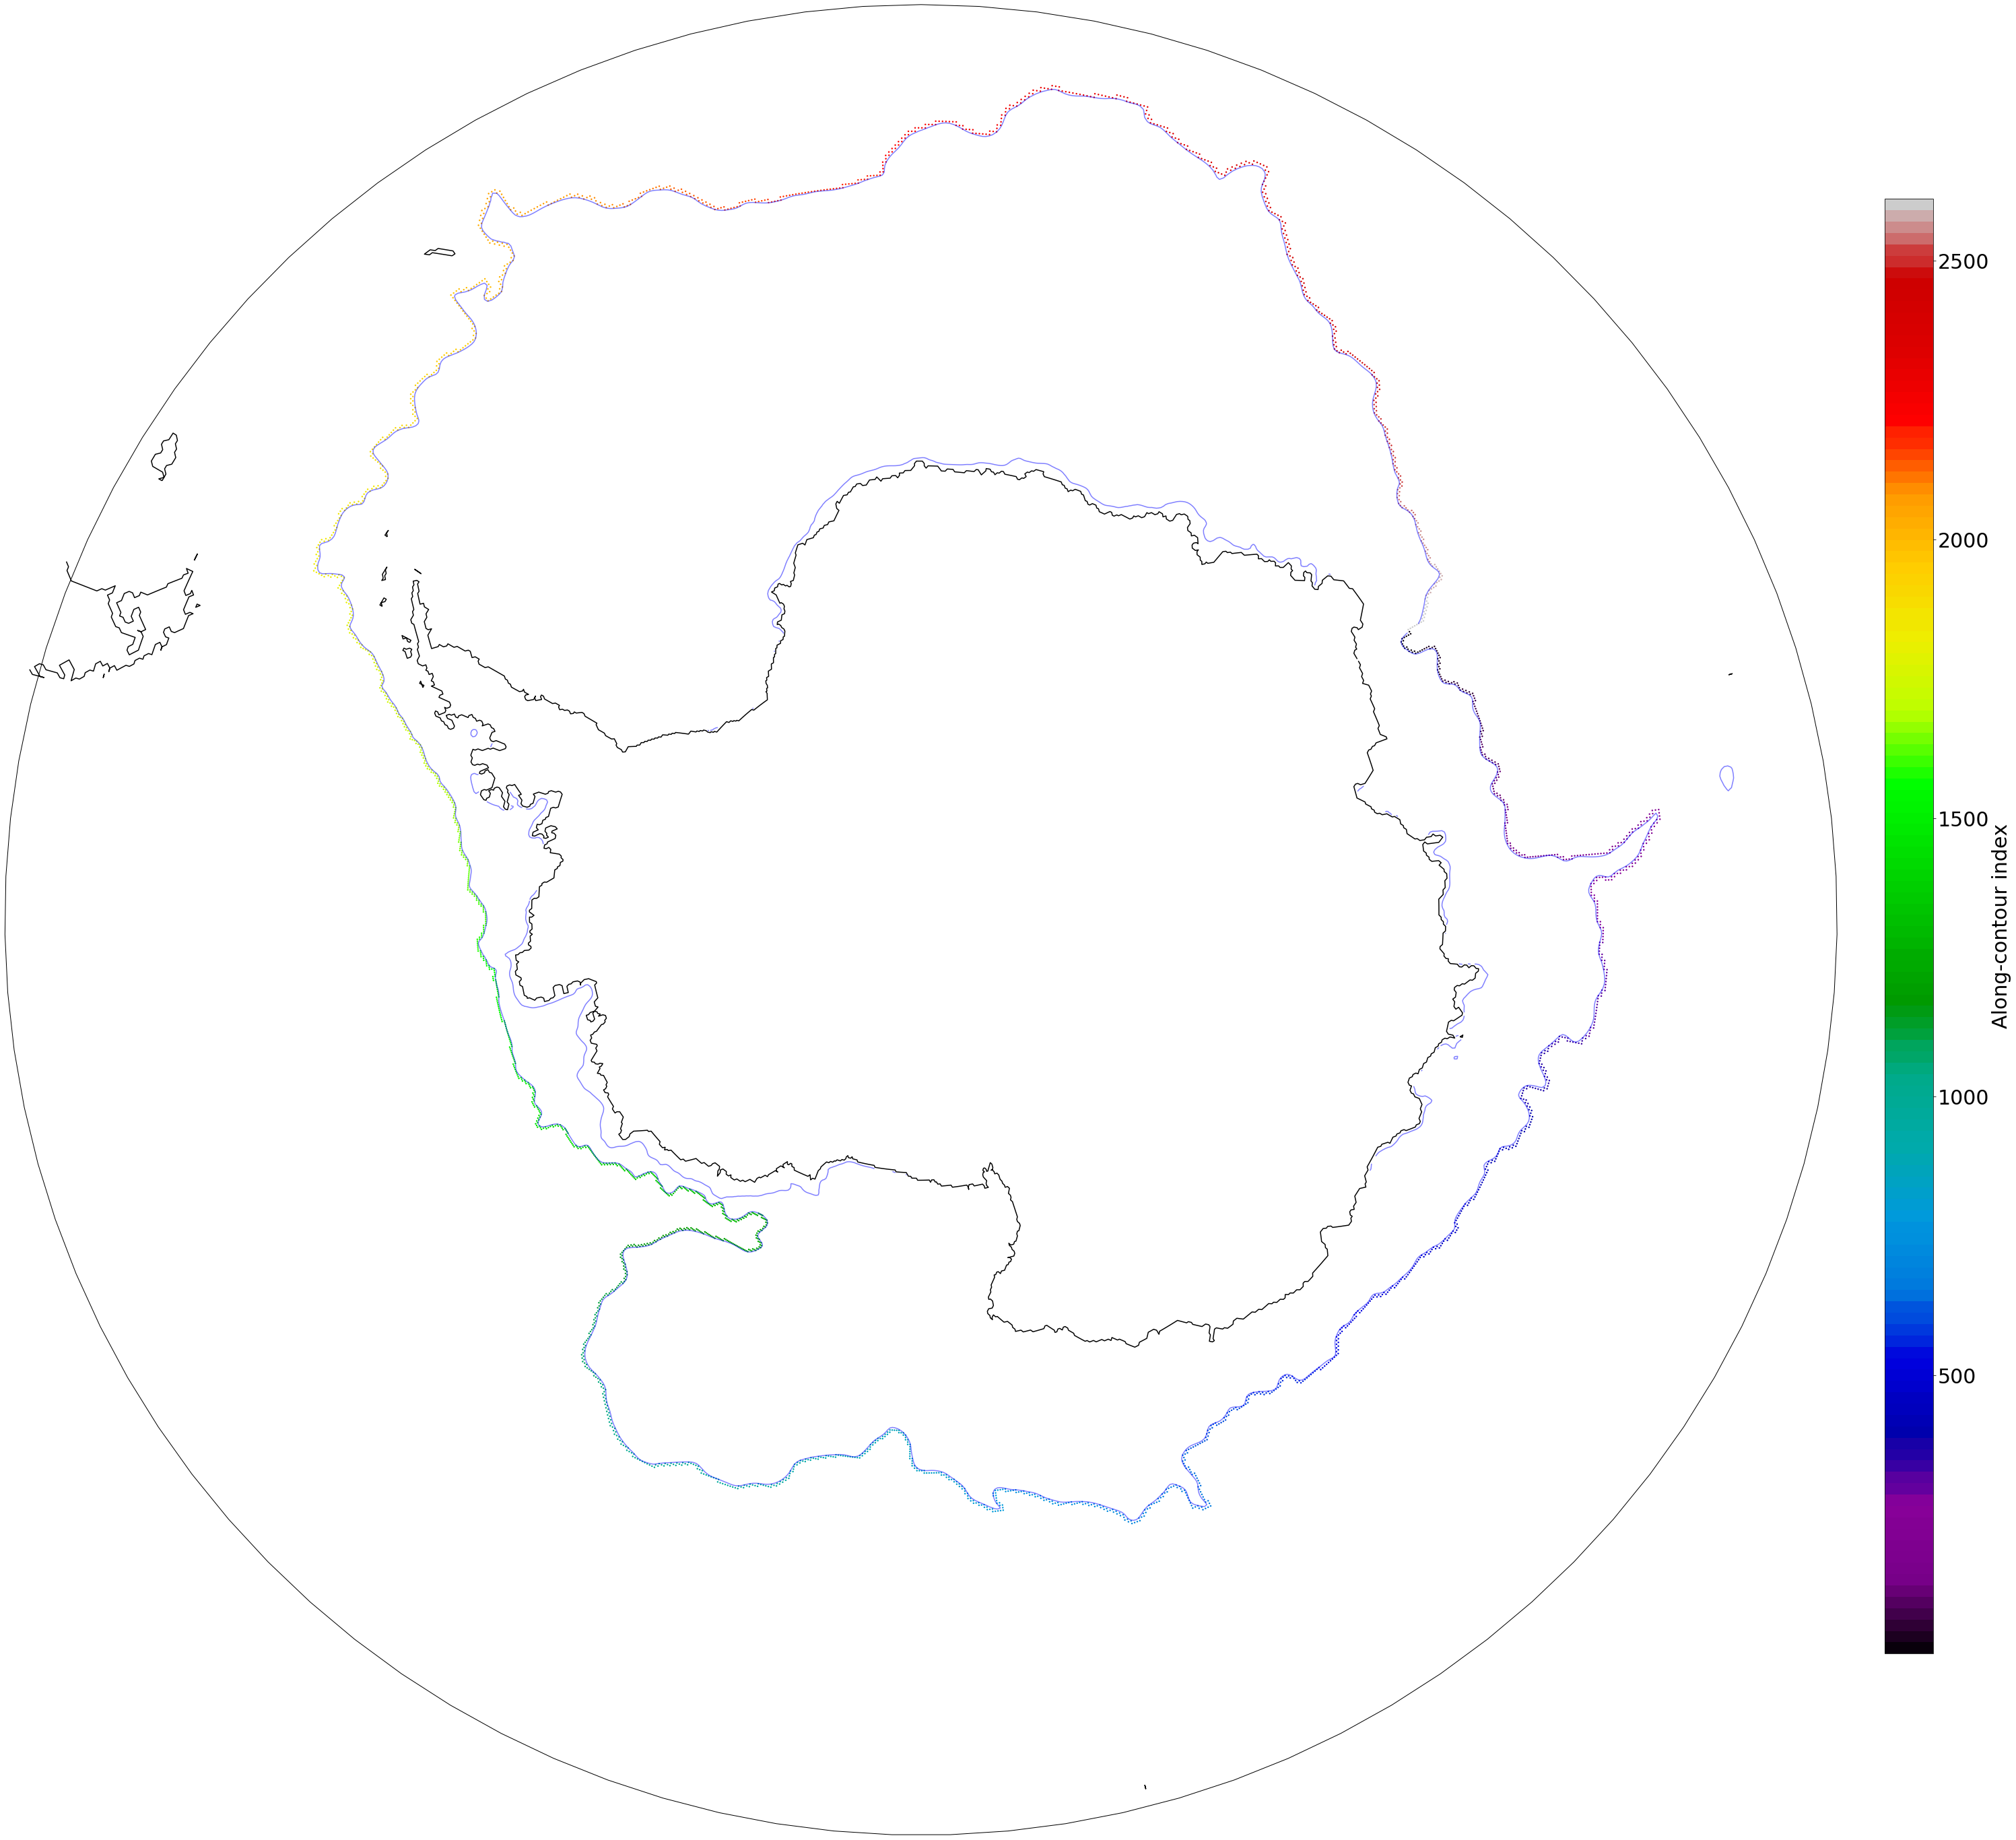

In [26]:
fig = plt.figure(figsize=[50, 50]) ## big to see the filled section over 0
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
ax.contour(ssh.xh, ssh.yh,ssh, levels = np.array([-1.6110]), colors = 'b',alpha = 0.5,transform = ccrs.PlateCarree())
plot = ax.scatter( .xh, contour_index.yh,c = contour_index, cmap = nclcmaps.cmap('MPL_Spectral'), s = 2, transform = ccrs.PlateCarree())
cax = fig.add_axes([0.91, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Along-contour index', fontsize = 30)
plt.show()

Now I'd like to have a way of determining the distance along these contours..

In [86]:
dxCu = static.dxCu # Delta(x) at u points (meter), is the distance between 2 zonally adjacent t points (yh, xq)
dyCv = static.dyCv # Delta(y) at v points (meter), is the distance between 2 meridionally adjacent t points (yq, xh)
# dxCu and dyCv are functions only of latitude
# well...some variation at very high latitudes but that isn't really important for us
dxCu = dxCu.mean(dim = 'xq').reset_coords(drop = True)
dyCv = dyCv.mean(dim = 'xh').reset_coords(drop = True)

In [58]:
distance_along_contour = xr.DataArray(np.zeros((len(contour_index))), coords = contour_index.coords)

In [85]:
distance_along_contour = xr.DataArray(np.zeros((len(contour_index))), coords = contour_index.coords)
for i in range(1,len(contour_index)):
    if contour_index[i].yh.values == contour_index[i-1].yh.values:
        distance_along_contour[i] = distance_along_contour[i-1] + dxCu.sel(yh = contour_index[i].yh)
        print('dxcu:',distance_along_contour[i].values)
    elif contour_index[i].xh.values == contour_index[i-1].xh.values:
        distance_along_contour[i] = distance_along_contour[i-1] + dyCv.sel(yq = (contour_index[i-1].yh+(contour_index[i].yh-contour_index[i-1].yh)/2), method = 'nearest')
        print('dycv:',distance_along_contour[i].values)

dxcu: 11819.5908203125
dycv: 23615.8603515625
dycv: 35365.583984375
dycv: 47068.9052734375
dycv: 58725.9677734375
dxcu: 70359.94921875
dycv: 81970.8974609375
dxcu: 93558.8369140625
dxcu: 105146.7763671875
dxcu: 116734.7158203125
dycv: 128345.6640625
dxcu: 139979.6455078125
dxcu: 151613.626953125
dycv: 163270.689453125
dxcu: 174950.857421875
dycv: 186654.1787109375
dxcu: 198380.6767578125
dycv: 210130.400390625
dycv: 221926.669921875
dycv: 233769.62890625
dycv: 245659.421875
dycv: 257596.1923828125
dycv: 269580.0849609375
dxcu: 281587.5859375
dycv: 293618.7431640625
dycv: 305697.30859375
dxcu: 317799.6259765625
dxcu: 329901.943359375
dxcu: 342004.2607421875
dxcu: 354106.578125
dxcu: 366208.8955078125
dycv: 378287.4609375
dxcu: 390342.2978515625
dxcu: 402397.134765625
dycv: 414428.2919921875
dxcu: 426435.79296875
dxcu: 438443.2939453125
dycv: 450427.1865234375
dxcu: 462387.494140625
dxcu: 474347.8017578125
dxcu: 486308.109375
dxcu: 498268.4169921875
dxcu: 510228.724609375
dycv: 522212.61

dxcu: 4610555.73828125
dycv: 4623814.703125
dxcu: 4637048.2470703125
dycv: 4650256.416015625
dxcu: 4663439.2333984375
dxcu: 4676622.05078125
dxcu: 4689804.8681640625
dxcu: 4702987.685546875
dycv: 4716195.8544921875
dxcu: 4729429.3984375
dycv: 4742688.36328125
dxcu: 4755972.7724609375
dycv: 4769282.6708984375
dxcu: 4782618.08203125
dxcu: 4795953.4931640625
dycv: 4809314.462890625
dxcu: 4822701.013671875
dycv: 4836113.19140625
dxcu: 4849551.01953125
dxcu: 4862988.84765625
dxcu: 4876426.67578125
dycv: 4889838.853515625
dxcu: 4903225.404296875
dycv: 4916586.3740234375
dycv: 4929896.2724609375
dycv: 4943155.2373046875
dycv: 4956363.40625
dycv: 4969520.9169921875
dycv: 4982627.9091796875
dxcu: 4995709.6875
dycv: 5008766.298828125
dxcu: 5021797.7666015625
dxcu: 5034829.234375
dxcu: 5047860.7021484375
dxcu: 5060892.169921875
dycv: 5073948.78125
dycv: 5087055.7734375
dxcu: 5100188.001953125
dycv: 5113345.5126953125
dxcu: 5126528.330078125
dycv: 5139736.4990234375
dxcu: 5152970.04296875
dycv: 51

dxcu: 9596917.627929688
dxcu: 9609600.8359375
dxcu: 9622284.043945312
dxcu: 9634967.251953125
dycv: 9647625.853515625
dxcu: 9660259.873046875
dxcu: 9672893.892578125
dxcu: 9685527.912109375
dxcu: 9698161.931640625
dxcu: 9710795.951171875
dycv: 9723405.434570312
dxcu: 9735990.40625
dxcu: 9748575.377929688
dycv: 9761135.884765625
dxcu: 9773671.951171875
dycv: 9786183.623046875
dxcu: 9798670.924804688
dxcu: 9811158.2265625
dycv: 9823621.206054688
dxcu: 9836059.885742188
dycv: 9848474.314453125
dxcu: 9860864.514648438
dxcu: 9873254.71484375
dycv: 9885620.734375
dxcu: 9897962.59765625
dxcu: 9910304.4609375
dycv: 9922622.21484375
dxcu: 9934915.8828125
dxcu: 9947209.55078125
dycv: 9959479.180664062
dxcu: 9971724.796875
dxcu: 9983970.413085938
dxcu: 9996216.029296875
dycv: 10008437.678710938
dxcu: 10020635.385742188
dxcu: 10032833.092773438
dxcu: 10045030.799804688
dxcu: 10057228.506835938
dycv: 10069402.318359375
dxcu: 10081552.258789062
dxcu: 10093702.19921875
dxcu: 10105852.139648438
dxcu: 

dycv: 13657453.331054688
dxcu: 13669087.3125
dycv: 13680698.260742188
dycv: 13692263.239257812
dxcu: 13703805.280273438
dycv: 13715324.432617188
dycv: 13726797.903320312
dxcu: 13738248.581054688
dycv: 13749676.513671875
dycv: 13761059.052734375
dycv: 13772396.342773438
dycv: 13783688.528320312
dycv: 13794935.752929688
dxcu: 13806160.544921875
dycv: 13817362.952148438
dycv: 13828520.6875
dycv: 13839633.89453125
dycv: 13850702.716796875
dxcu: 13861749.395507812
dycv: 13872773.977539062
dycv: 13883754.463867188
dxcu: 13894712.950195312
dycv: 13905823.624023438
dycv: 13917097.46875
dxcu: 13927966.107421875
dycv: 13939239.952148438
dycv: 13950513.796875
dycv: 13961787.641601562
dxcu: 13972520.274414062
dycv: 13983794.119140625
dycv: 13995067.963867188
dxcu: 14005709.756835938
dycv: 14016983.6015625
dycv: 14028257.446289062
dycv: 14039531.291015625
dycv: 14050805.135742188
dycv: 14062078.98046875
dxcu: 14072493.096679688
dycv: 14083766.94140625
dycv: 14095040.786132812
dycv: 14106314.6308593

dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dycv: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dycv: nan
dycv: nan
dycv: nan
dxcu: nan
dycv: nan
dycv: nan
dycv: nan
dycv: nan
dycv: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dycv: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan
dxcu: nan
dxcu: nan
dycv: nan
dycv: nan
dxcu: nan
dycv: nan
dxcu: nan
dycv: nan
dycv: nan
dxcu: nan
dycv: nan
dxcu: nan
dycv: nan
dxcu: nan
dxcu: nan


In [83]:
distance_along_contour

<xarray.DataArray (contour_index: 2612)>
array([    0.        , 11819.59082031, 23615.86035156, ...,
                  nan,            nan,            nan])
Coordinates:
  * contour_index  (contour_index) float32 1.0 2.0 3.0 ... 2610.0 2611.0 2612.0
    yh             (contour_index) float64 -64.87 -64.87 ... -64.76 -64.87
    xh             (contour_index) float64 -299.7 -299.5 -299.5 ... 60.03 60.03

In [39]:
np.unique(a, axis = 1)

array([[0, 1],
       [0, 2]])

In [27]:
contour_index

<xarray.DataArray (contour_index: 2612)>
array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.610e+03, 2.611e+03,
       2.612e+03], dtype=float32)
Coordinates:
  * contour_index  (contour_index) float32 1.0 2.0 3.0 ... 2610.0 2611.0 2612.0
    yh             (contour_index) float64 -64.87 -64.87 ... -64.76 -64.87
    xh             (contour_index) float64 -299.7 -299.5 -299.5 ... 60.03 60.03
Attributes:
    description:  Southernmost continous circumpolar ssh contour (value -1.61...

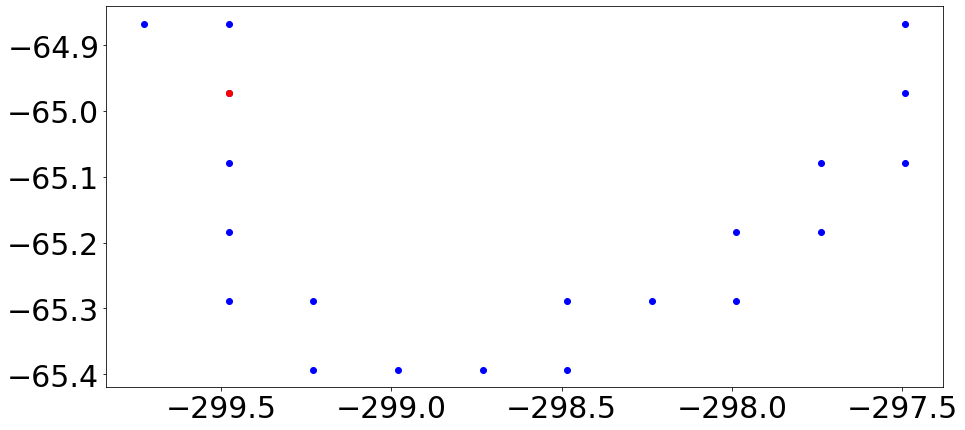

In [28]:
plt.figure(figsize = (15,7))
ax = plt.subplot()
ax.plot(contour_index.xh[:20], contour_index.yh[:20], 'bo')
ax.plot(contour_index.xh[2], contour_index.yh[2], 'ro')
plt.show()

In [31]:
dxt = static.dxt
dyt = static.dyt

In [32]:
dxt

<xarray.DataArray 'dxt' (yh: 1080, xh: 1440)>
[1555200 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Attributes:
    long_name:      Delta(x) at thickness/tracer points (meter)
    units:          m
    cell_methods:   time: point
    interp_method:  none

Note: The above is the quickest method but not the most fullproof.
A lsower method is described below which makes sure no continous contours are mistakenly marked as discontinuous.
```
for contour_depth in np.arange(-1.7,-1.5,0.001):
    print(contour_depth)
    lat_north = -29
    # initial basic masking
    temp = ssh.where(ssh<=contour_depth) * 0 + 1
    temp_mask = ssh.copy().fillna(1)
    xh = temp_mask.xh
    yh = temp_mask.yh
    temp_mask = temp_mask.where(temp_mask <= contour_depth) * 0 + 1
    temp_mask = temp_mask.fillna(0)
    temp_mask = temp_mask.values # extract numpy file
    # # this spreads the isobath contour so all points are connected adjacently (not just 
    # # diagonally):
    kernel = np.ones((3,3),np.uint8)
    contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
    # start at western edge of domain, at y point closest to correct depth contour:
    contour_mask = np.zeros_like(temp_mask) 
    contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
    contour_mask[contour_lat_index_start,0] = 1
    # loop through to find adjacent point closest to contour depth (not inc previous point):
    last_index_i = np.array([0])
    last_index_j = contour_lat_index_start
    count = np.array([0])
    while last_index_i<(len(xh)-1): # 1440 is xh dimension length
        # first time don't go backwards:
        if last_index_i == 0:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                0,
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
        else:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                contour_mask0[last_index_j,last_index_i-1],
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
        new_loc = np.where(points_to_compare==1)[0]
        # this gives each point along contour a unique index number:
        if len(new_loc)==0:
            contour_mask0[last_index_j,last_index_i] = 0
            count = count - 1
            last_index_i = np.where(contour_mask==count+1)[1]
            last_index_j = np.where(contour_mask==count+1)[0]
            if len(last_index_i)>1:
                last_index_i = last_index_i[0]
                last_index_j = last_index_j[0]
            else:
                continue
        elif len(new_loc)>0:
            if new_loc[0] == 0:
                new_index_i = last_index_i+1
                new_index_j = last_index_j
            elif new_loc[0] == 1:
                new_index_i = last_index_i-1
                new_index_j = last_index_j
            elif new_loc[0] == 2:
                new_index_i = last_index_i
                new_index_j = last_index_j+1            
            elif new_loc[0] == 3:
                new_index_i = last_index_i
                new_index_j = last_index_j-1

            contour_mask[new_index_j,new_index_i] = count + 2
            contour_mask0[last_index_j,last_index_i] = 2
            last_index_j = new_index_j
            last_index_i = new_index_i
            count += 1
            if len(np.array([last_index_i])) >1:
                last_index_i = last_index_i[0]
                last_index_j = last_index_j[0]
    print(np.sum(contour_mask, axis = 0).min())
```
Basically,stop when the sum becomes 1. This is a slow method though.

Secondly, it would be good to functionalize the contour generation for observational data as well.

In [176]:
range_tested = np.arange(-1.1,-0.9,0.001)

In [186]:
def CMEMS_southernmost_continuous_ssh_contour(ssh, range_tested, lat_north):
    """
    Script to find the southernmost circumpolar continuous ssh contour from CMEMS obs.
    Will test each contour value in range_tested, terminating at the first value of range_tested for which a circumpolar continuous contour may be constructed.
    As such, the input range_tested must be intelligently defined such that the first values tested refer to the value fo the field very close to the Antarctic coast.
    As we move through range_tested, the value of range_tested should be ound in the field further and further away from the coast.
    For example, the script was designed with a mind to find the southernmost continuous ssh contour, and in this case a range_tested ranging from strongly negative values upward should work (e.g. np.arange(-1.1,-0.9,0.001)).
    Prints the field value that produces the southermost circumpolar contour. (if nothing printed or printed value is first value in range_tested, alter range_tested)
    
    returns contour_mask_numbered, contour_masked_south, contour_index
    
    contour_mask_numbered (xarray) = 0 off the contour, nonzero on the contour. Points on the contour are numbered seuqentially.
    contour_mask_south (xarray) = Gridpoints on and polewards of the contour are 1, points equatorward of the contour are nan.
    contour_index (xarray) = lat and lon positions of each numbered point on the contour. An along-contour index.
    
    Ruth Moorman, Princeton University, May 2020
    """
    for contour_depth in range_tested:
    #     print(contour_depth)
        # initial basic masking
        temp = ssh.where(cmems_obs_mean<=contour_depth) * 0 + 1
        temp_mask = ssh.copy().fillna(1)
        xh = temp_mask.longitude
        yh = temp_mask.latitude
        temp_mask = temp_mask.where(temp_mask <= contour_depth) * 0 + 1
        temp_mask = temp_mask.fillna(0)
        temp_mask = temp_mask.values # extract numpy file
        # # this spreads the isobath contour so all points are connected adjacently (not just 
        # # diagonally):
        kernel = np.ones((3,3),np.uint8)
        contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
        # start at western edge of domain, at y point closest to correct depth contour:
        contour_mask = np.zeros_like(temp_mask) 
        contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
        contour_mask[contour_lat_index_start,0] = 1
        # loop through to find adjacent point closest to contour depth (not inc previous point):
        last_index_i = np.array([0])
        last_index_j = contour_lat_index_start
        count = 0
        while last_index_i<(len(xh)-1):
            # first time don't go backwards:
            if last_index_i == 0:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    0,
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            else:
                points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                    contour_mask0[last_index_j,last_index_i-1],
                    contour_mask0[last_index_j+1,last_index_i],
                    contour_mask0[last_index_j-1,last_index_i]])
            new_loc = np.where(points_to_compare==1)[0]
            # this gives each point along contour a unique index number:
            if len(new_loc)==0:
                contour_mask0[last_index_j,last_index_i] = 0
                count = count - 1
                last_index_i = np.where(contour_mask==count+1)[1]
                last_index_j = np.where(contour_mask==count+1)[0]
                if len(last_index_i) != 1:
    #                 print('No circumpolar continuous contour at ssh = ',contour_depth)
                    break
                else:
                    continue
            elif len(new_loc)>0:
                if new_loc[0] == 0:
                    new_index_i = last_index_i+1
                    new_index_j = last_index_j
                elif new_loc[0] == 1:
                    new_index_i = last_index_i-1
                    new_index_j = last_index_j
                elif new_loc[0] == 2:
                    new_index_i = last_index_i
                    new_index_j = last_index_j+1
                elif new_loc[0] == 3:
                    new_index_i = last_index_i
                    new_index_j = last_index_j-1
                contour_mask[new_index_j,new_index_i] = count + 2
                contour_mask0[last_index_j,last_index_i] = 2
                last_index_j = new_index_j
                last_index_i = new_index_i
                count += 1
                if len(last_index_i) != 1:
    #                 print('No circumpolar continuous contour')
                    break
        if np.sum(contour_mask, axis = 0).min() == 1:
            print('Southernmost circumpolar continuous profile at ssh = ', contour_depth)
            break
    # # this is the sequentially numbered isobath, it provides an along isobath index
    contour_mask_numbered = contour_mask
    # sometimes there's a discontinuoity at 0
    #     if last_index_j > contour_lat_index_start:
    #         a = 0
    #         for m in np.arange(last_index_j,contour_lat_index_start-1, -1):
    #             contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1] +a
    #             a += 1
    #     elif last_index_j < contour_lat_index_start:
    #         a = 0
    #         for m in np.arange(last_index_j, contour_lat_index_start+1, 1):
    #             contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1].values +a
    #             a += 1
    # fill in points to north of contour:
    contour_masked_above = np.copy(contour_mask_numbered)
    contour_masked_above[-1,0] = -100

    # from top left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj-1,ii+1] == 0:
                    contour_masked_above[jj-1,ii+1] = -100
    # from top right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj-1,ii-1] == 0:
                    contour_masked_above[jj-1,ii-1] = -100
    # from bottom right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj+1,ii-1] == 0:
                    contour_masked_above[jj+1,ii-1] = -100
    # from bottom left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj+1,ii+1] == 0:
                    contour_masked_above[jj+1,ii+1] = -100
    contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['latitude', 'longitude'])
    contour_mask_numbered.attrs['description'] = 'Southernmost continous circumpolar ssh contour (value '+str(contour_depth)[:6]+'m). Points on the contour are numbered sequentially, providing an along-contour index.'
    contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['latitude', 'longitude'])
    contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
    contour_masked_south.attrs['description'] = 'Masks for the region south of the southernmost continous circumpolar ssh contour (value '+str(contour_depth)[:6]+'m). Gridpoints on and polewards of the contour are 1, points equatorward of the contour are nan.'

    contour_mask_numbered_1D = contour_mask_numbered.stack(contour_position = ['latitude','longitude'])
    contour_mask_numbered_1D = contour_mask_numbered_1D.where(contour_mask_numbered_1D>0, drop = True)
    contour_index = contour_mask_numbered_1D.sortby(contour_mask_numbered_1D)
    lat_along_contour = xr.DataArray(contour_index.latitude, coords = [contour_index.values], dims = 'contour_index')
    lon_along_contour = xr.DataArray(contour_index.longitude, coords = [contour_index.values], dims = 'contour_index')
    contour_index = xr.DataArray(contour_index, coords = [contour_index.values], dims = 'contour_index')
    contour_index = xr.DataArray(contour_index, coords = {'contour_index':contour_index, 'latitude': lat_along_contour, 'longitude': lon_along_contour} )
    return contour_mask_numbered, contour_masked_south, contour_index

In [187]:
contour_mask_numbered, contour_masked_south, contour_index = CMEMS_southernmost_continuous_ssh_contour(cmems_obs_mean, np.arange(-1.1,-0.9,0.001), lat_north)

Southernmost circumpolar continuous profile at ssh =  -1.064000000000004


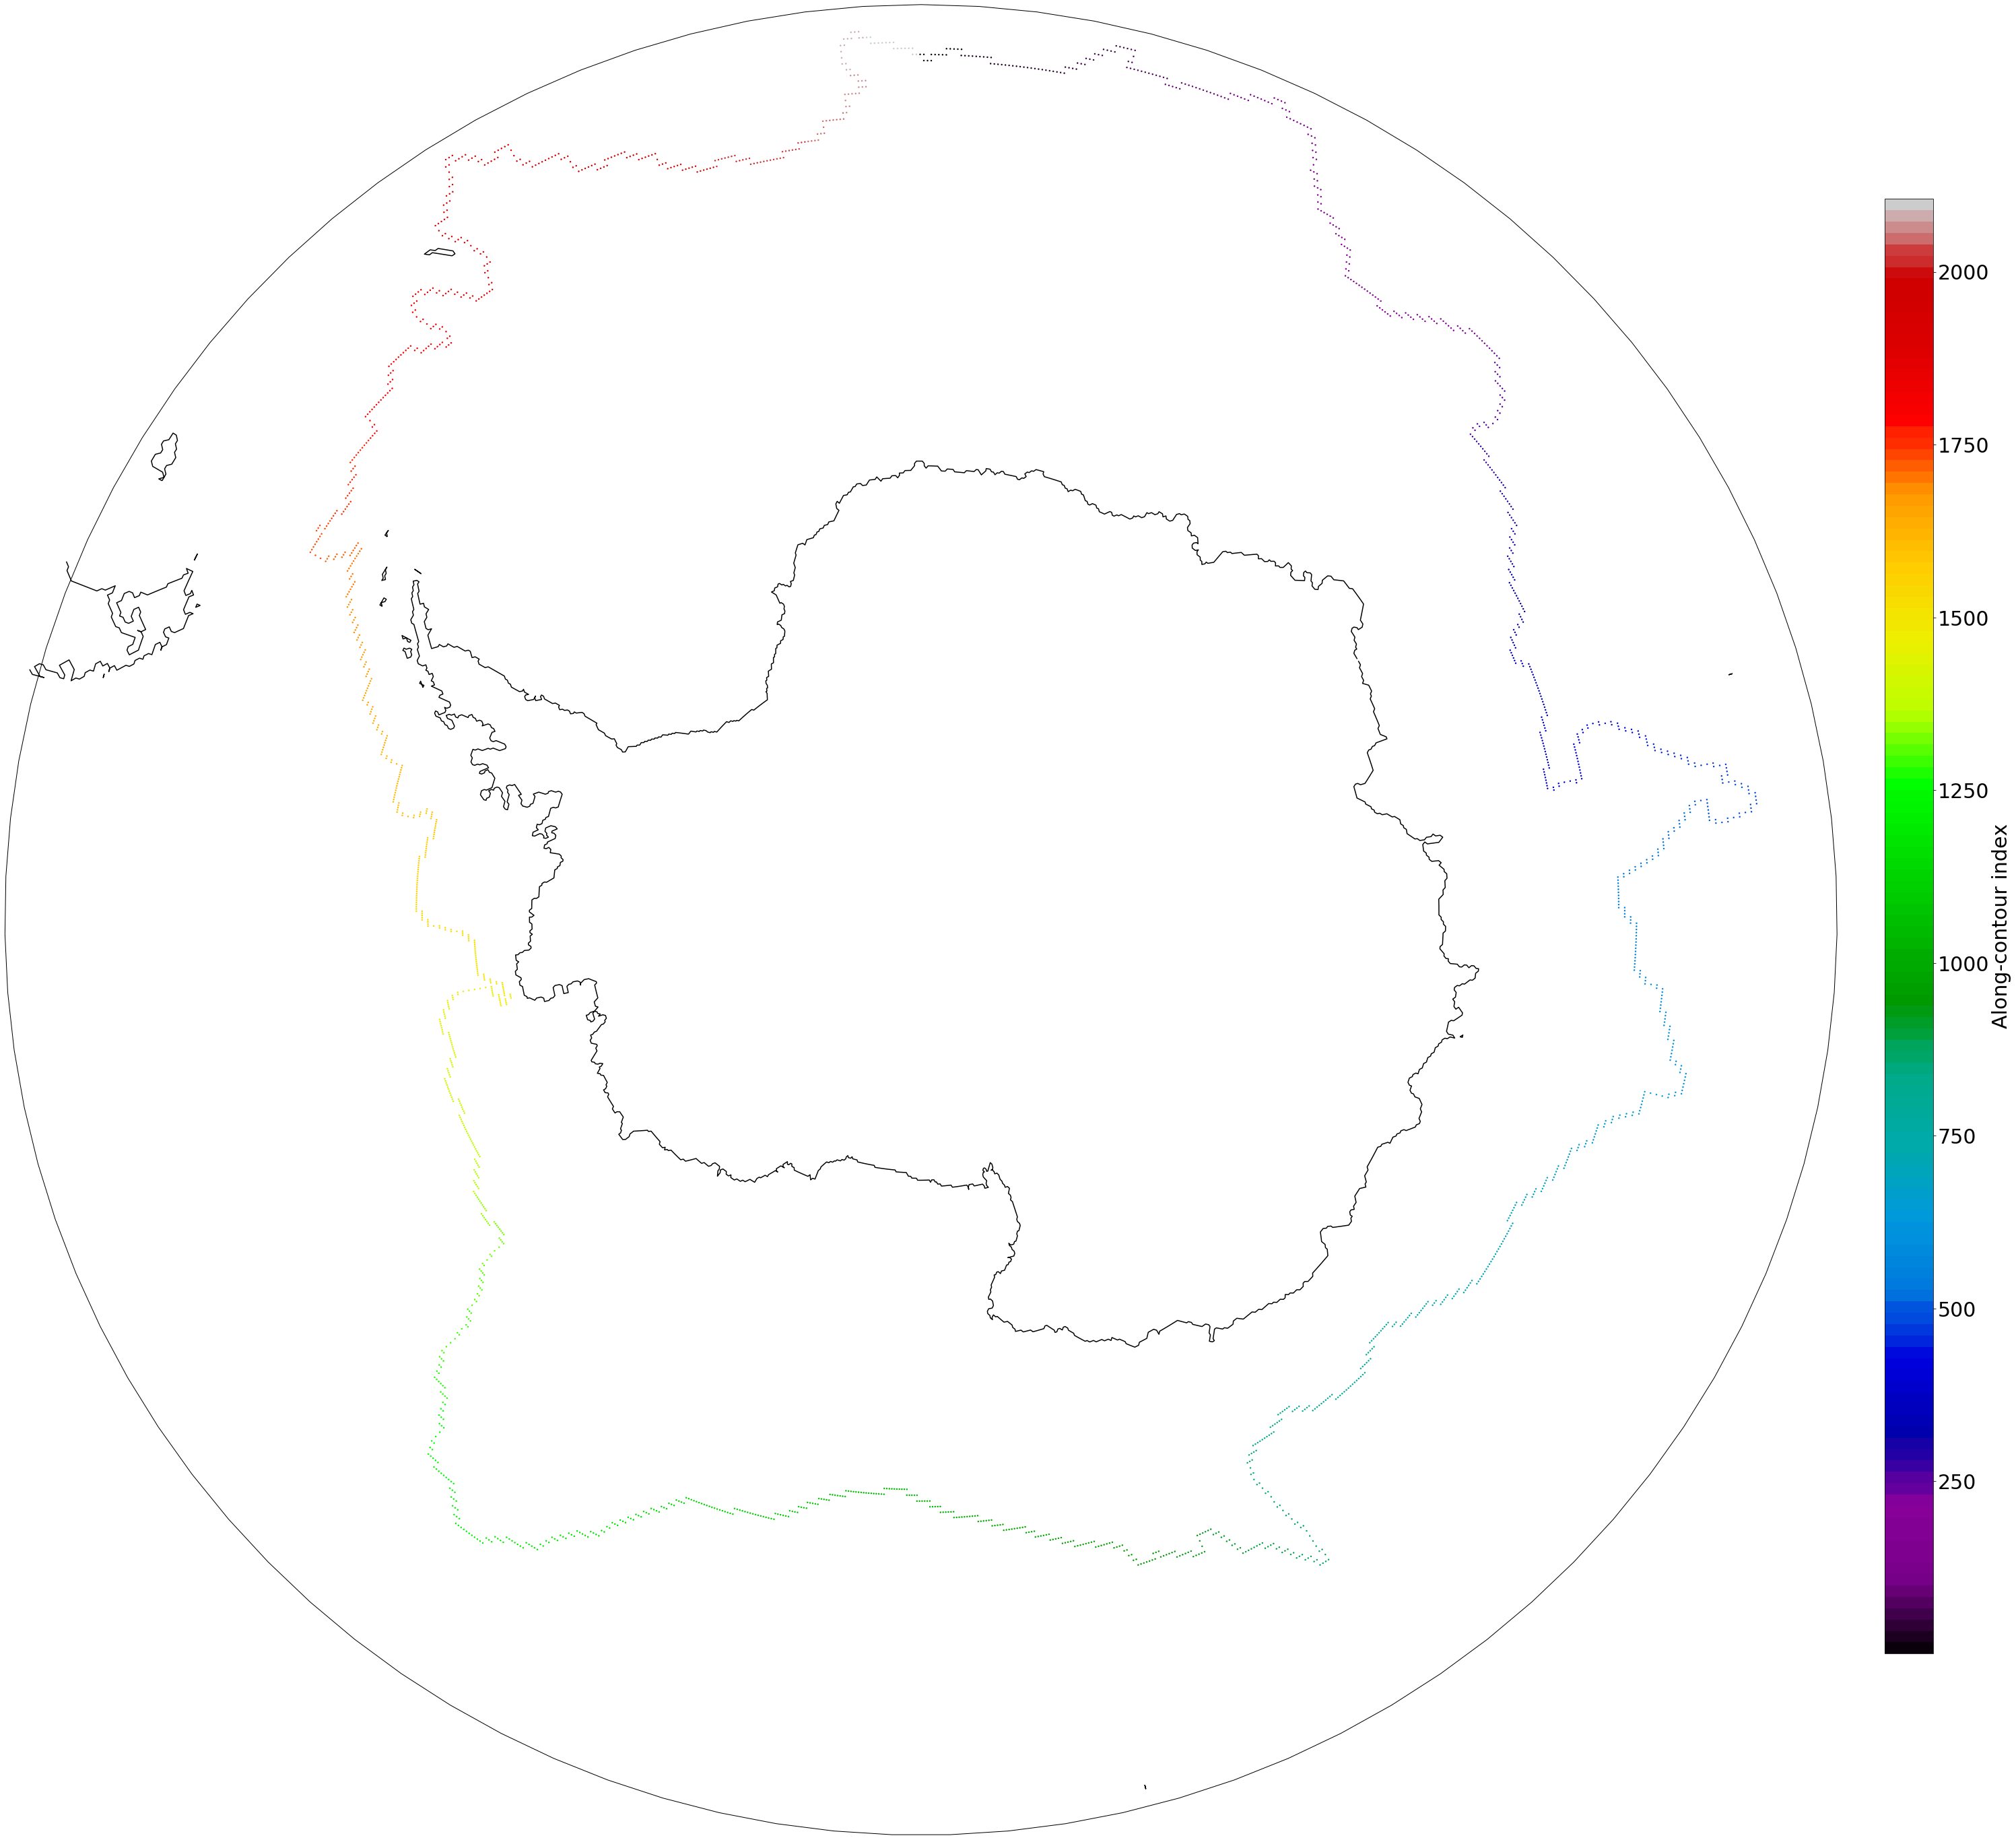

In [182]:
fig = plt.figure(figsize=[50, 50])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
# ax.contour(xh, yh,contour_mask, levels = [0,1], colors = ['k'], alpha = 0.5, transform = ccrs.PlateCarree())
plot = ax.scatter(contour_index.longitude, contour_index.latitude,c = contour_index, cmap = nclcmaps.cmap('MPL_Spectral'), s = 2, transform = ccrs.PlateCarree())
cax = fig.add_axes([0.91, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('Along-contour index', fontsize = 30)
plt.show()

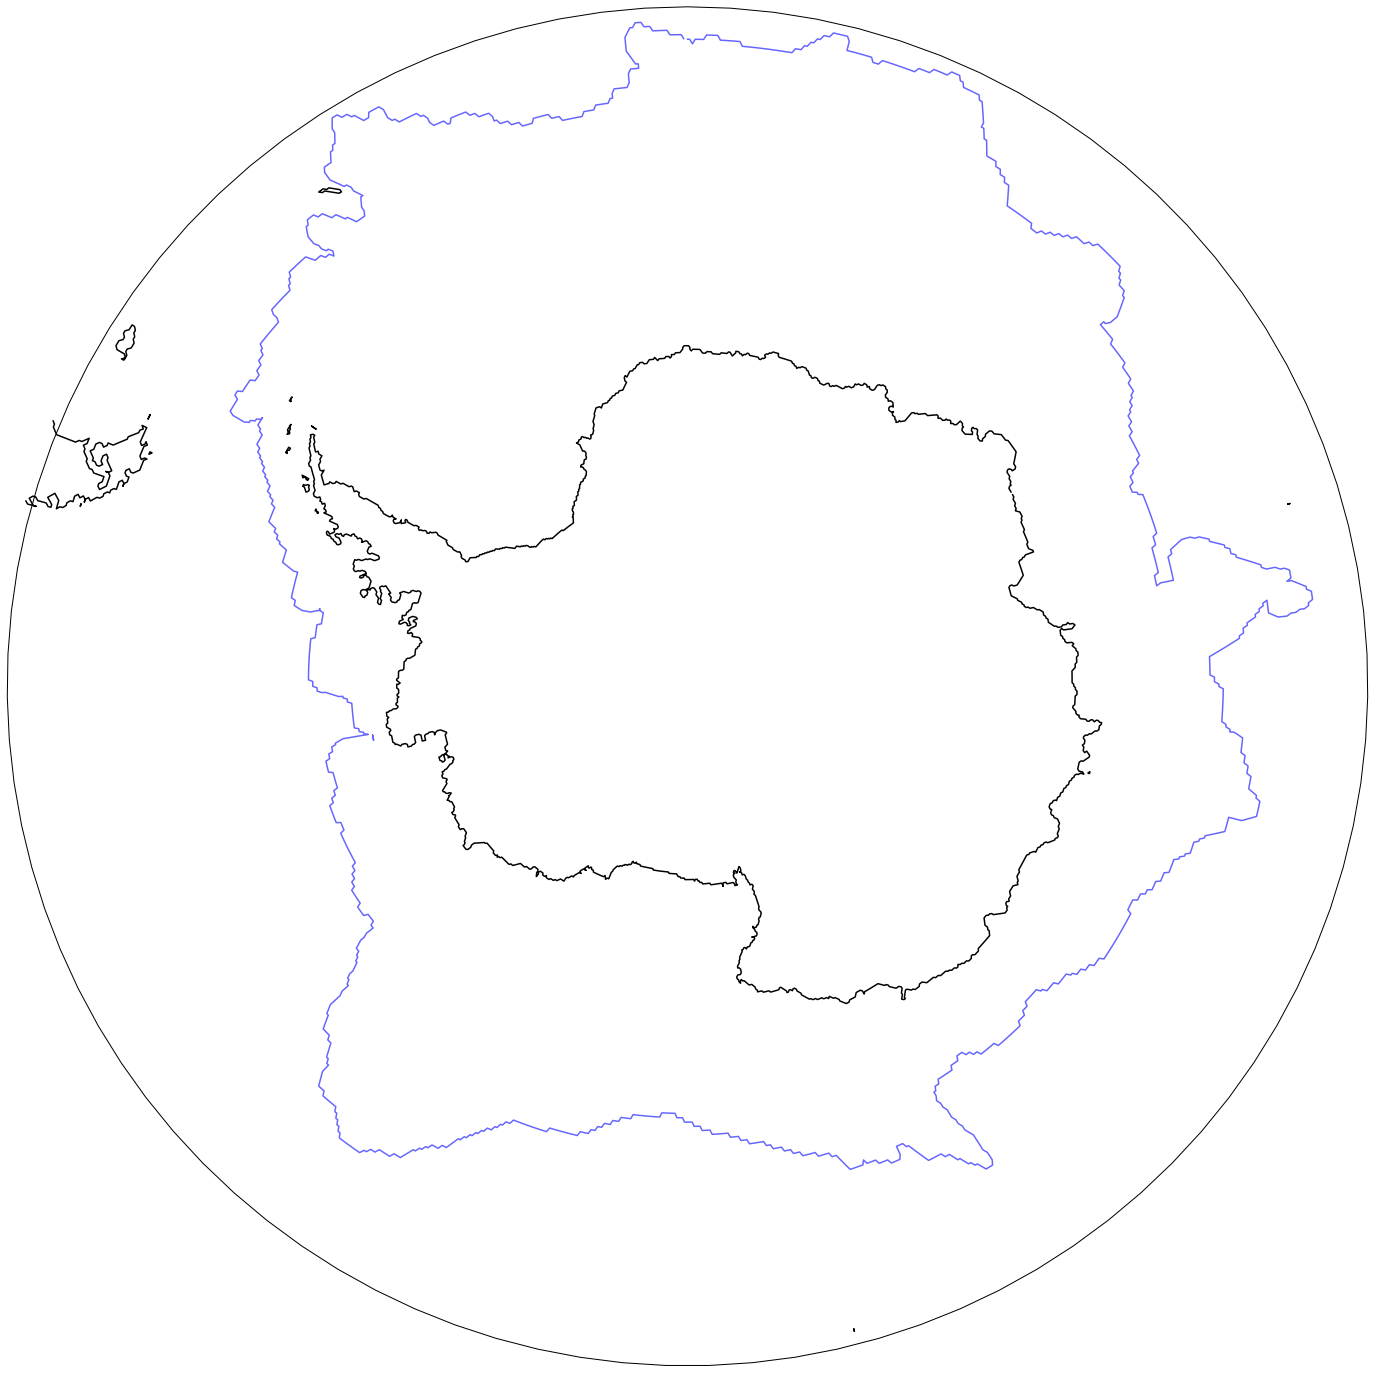

In [184]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
ax.contour(contour_masked_south.sel(latitude = slice(-90,lat_north)).longitude, contour_masked_south.sel(latitude = slice(-90,lat_north)).latitude,contour_masked_south.sel(latitude = slice(-90,lat_north)).fillna(0), levels = [0,1], colors = 'b', alpha = 0.6, transform = ccrs.PlateCarree())
plt.show()

In [189]:
ssh

<xarray.DataArray 'zos' (yh: 382, xh: 1440)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.3881348 , 0.38644773, 0.38435063, ..., 0.39130923, 0.39039353,
        0.3894363 ],
       [0.39188287, 0.3901009 , 0.38783237, ..., 0.39534768, 0.3941947 ,
        0.39315277],
       [0.3955266 , 0.39370576, 0.39140216, ..., 0.39936247, 0.3979883 ,
        0.396866  ]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... -29.59 -29.37 -29.15
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03

In [191]:
contour_depth = -1.5
# initial basic masking
temp = ssh.where(ssh<=contour_depth) * 0 + 1
temp_mask = ssh.copy().fillna(1)
xh = temp_mask.xh
yh = temp_mask.yh
temp_mask = temp_mask.where(temp_mask <= contour_depth) * 0 + 1
temp_mask = temp_mask.fillna(0)
temp_mask = temp_mask.values # extract numpy file
# # this spreads the isobath contour so all points are connected adjacently (not just 
# # diagonally):
kernel = np.ones((3,3),np.uint8)
contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
# start at western edge of domain, at y point closest to correct depth contour:
contour_mask = np.zeros_like(temp_mask) 
contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
contour_mask[contour_lat_index_start,0] = 1
# loop through to find adjacent point closest to contour depth (not inc previous point):
last_index_i = np.array([0])
last_index_j = contour_lat_index_start
count = 0
while last_index_i<(len(xh)-1):
    # first time don't go backwards:
    if last_index_i == 0:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
            0,
            contour_mask0[last_index_j+1,last_index_i],
            contour_mask0[last_index_j-1,last_index_i]])
    else:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
            contour_mask0[last_index_j,last_index_i-1],
            contour_mask0[last_index_j+1,last_index_i],
            contour_mask0[last_index_j-1,last_index_i]])
    new_loc = np.where(points_to_compare==1)[0]
    # this gives each point along contour a unique index number:
    if len(new_loc)==0:
        contour_mask0[last_index_j,last_index_i] = 0
        count = count - 1
        last_index_i = np.where(contour_mask==count+1)[1]
        last_index_j = np.where(contour_mask==count+1)[0]
        if len(last_index_i) != 1:
#                     print('No circumpolar continuous contour at ssh = ',contour_depth)
            break
        else:
            continue
    elif len(new_loc)>0:
        if new_loc[0] == 0:
            new_index_i = last_index_i+1
            new_index_j = last_index_j
        elif new_loc[0] == 1:
            new_index_i = last_index_i-1
            new_index_j = last_index_j
        elif new_loc[0] == 2:
            new_index_i = last_index_i
            new_index_j = last_index_j+1
        elif new_loc[0] == 3:
            new_index_i = last_index_i
            new_index_j = last_index_j-1
        contour_mask[new_index_j,new_index_i] = count + 2
        contour_mask0[last_index_j,last_index_i] = 2
        last_index_j = new_index_j
        last_index_i = new_index_i
        count += 1
        if len(last_index_i) != 1:
#                     print('No circumpolar continuous contour')
            break
# # this is the sequentially numbered isobath, it provides an along isobath index
contour_mask_numbered = contour_mask
# sometimes there's a discontinuoity at 0
if last_index_j > contour_lat_index_start:
    a = 0
    for m in np.arange(last_index_j,contour_lat_index_start-1, -1):
        contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1] +a
        a += 1
elif last_index_j < contour_lat_index_start:
    a = 0
    for m in np.arange(last_index_j, contour_lat_index_start+1, 1):
        contour_mask_numbered[m,-1] = contour_mask_numbered[last_index_j,-1].values +a
        a += 1
# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1,0] = -100

# from top left:
for ii in range(len(xh)-1):
    for jj in range(len(yh))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj-1,ii+1] == 0:
                contour_masked_above[jj-1,ii+1] = -100
# from top right:
for ii in range(len(xh))[::-1][:-1]:
    for jj in range(len(yh))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj-1,ii-1] == 0:
                contour_masked_above[jj-1,ii-1] = -100
# from bottom right:
for ii in range(len(xh))[::-1][:-1]:
    for jj in range(len(yh)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj+1,ii-1] == 0:
                contour_masked_above[jj+1,ii-1] = -100
# from bottom left:
for ii in range(len(xh)-1):
    for jj in range(len(yh)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj+1,ii+1] == 0:
                contour_masked_above[jj+1,ii+1] = -100
contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['yh', 'xh'])
contour_mask_numbered.attrs['description'] = 'Southernmost continous circumpolar ssh contour (value '+str(contour_depth)[:6]+'m). Points on the contour are numbered sequentially, providing an along-contour index.'
contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['yh', 'xh'])
contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
contour_masked_south.attrs['description'] = 'Masks for the region south of the southernmost continous circumpolar ssh contour (value '+str(contour_depth)[:6]+'m). Gridpoints on and polewards of the contour are 1, points equatorward of the contour are nan.'

contour_mask_numbered_1D = contour_mask_numbered.stack(contour_position = ['yh','xh'])
contour_mask_numbered_1D = contour_mask_numbered_1D.where(contour_mask_numbered_1D>0, drop = True)
contour_index = contour_mask_numbered_1D.sortby(contour_mask_numbered_1D)
lat_along_contour = xr.DataArray(contour_index.yh, coords = [contour_index.values], dims = 'contour_index')
lon_along_contour = xr.DataArray(contour_index.xh, coords = [contour_index.values], dims = 'contour_index')
contour_index = xr.DataArray(contour_index, coords = [contour_index.values], dims = 'contour_index')
contour_index = xr.DataArray(contour_index, coords = {'contour_index':contour_index, 'yh': lat_along_contour, 'xh': lon_along_contour} )


Southernmost circumpolar continuous profile at ssh =  -1.5


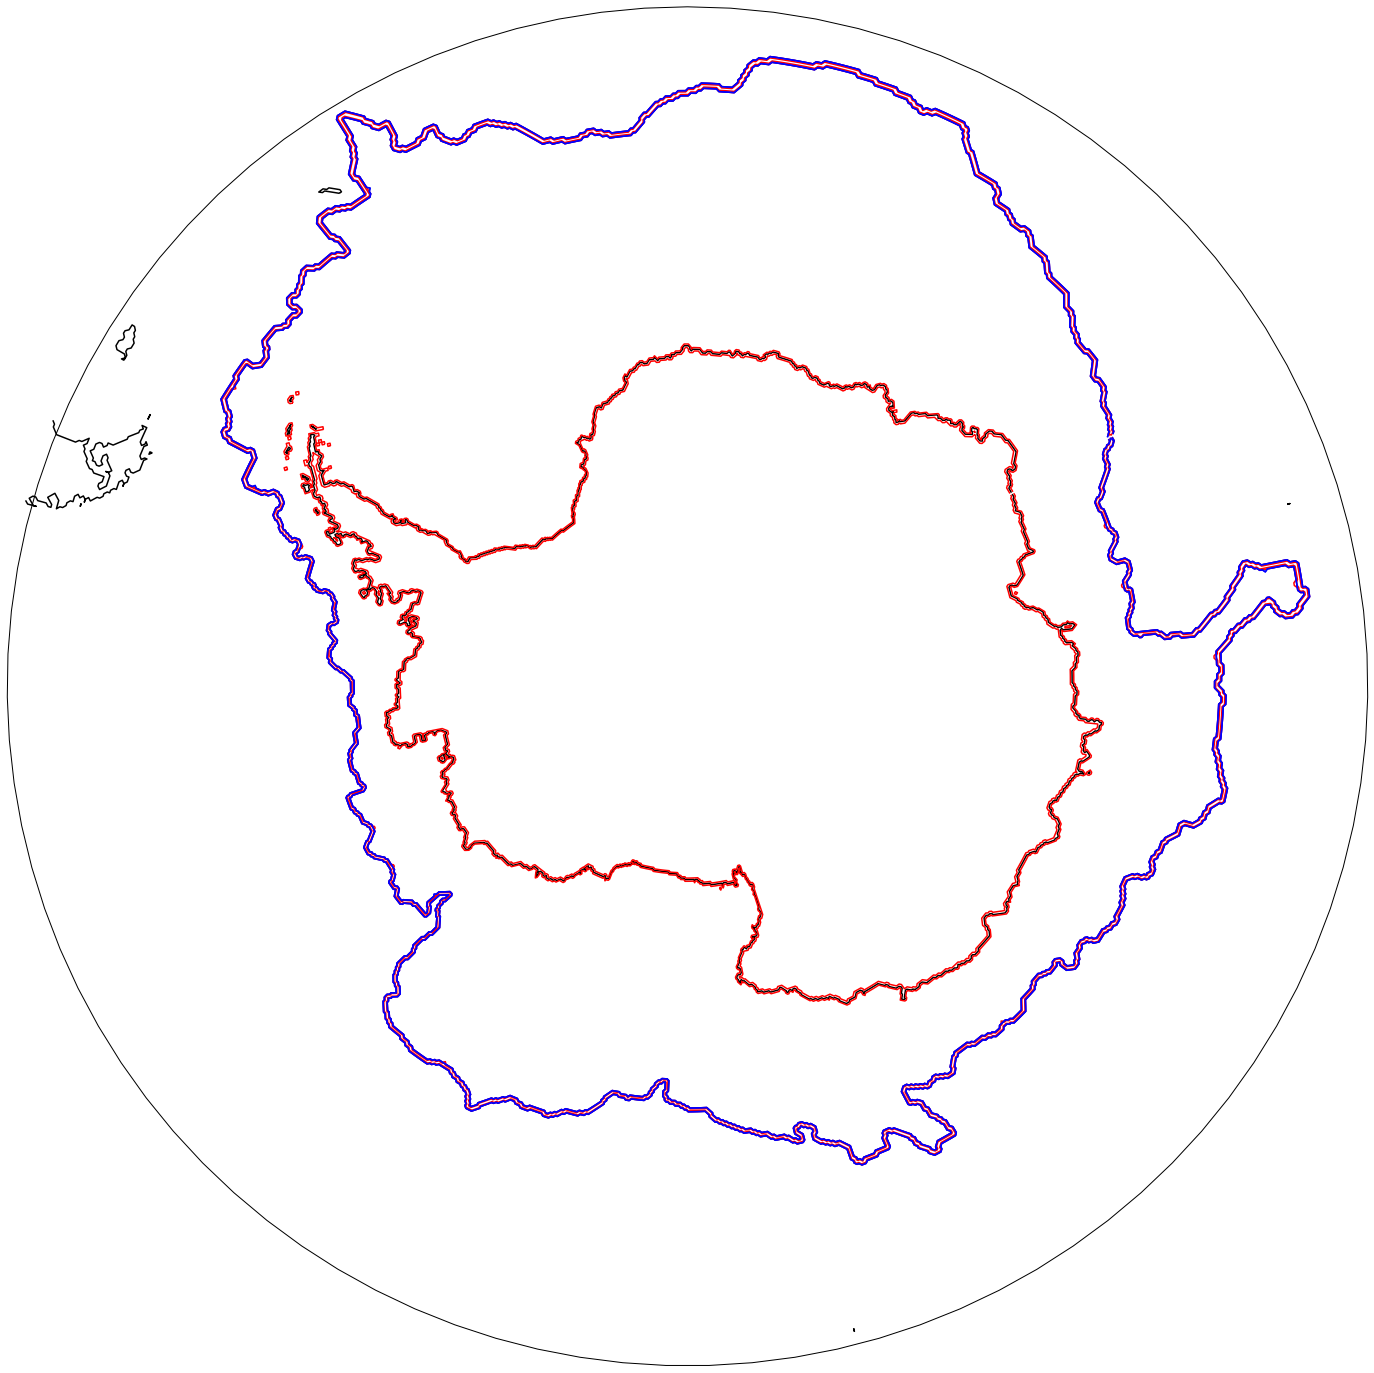

In [194]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
# basic contour - no attempt at isolating a continuous circumpolar feature
ax.contour(xh, yh,contour_mask0, levels = [0,1], colors = ['r'], alpha = 1, transform = ccrs.PlateCarree())
# circumpolar continuous isobath
ax.contour(xh, yh,contour_mask, levels = [0,1], colors = ['b'], alpha = 1, transform = ccrs.PlateCarree())
plt.show()

In [197]:
contour_mask0.max()

2.0

In [205]:
temp_mask[:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [206]:
ssh

<xarray.DataArray 'zos' (yh: 382, xh: 1440)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.3881348 , 0.38644773, 0.38435063, ..., 0.39130923, 0.39039353,
        0.3894363 ],
       [0.39188287, 0.3901009 , 0.38783237, ..., 0.39534768, 0.3941947 ,
        0.39315277],
       [0.3955266 , 0.39370576, 0.39140216, ..., 0.39936247, 0.3979883 ,
        0.396866  ]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... -29.59 -29.37 -29.15
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03

In [207]:
contour_depth = -1.5
# initial basic masking
temp = ssh.where(ssh<=contour_depth) * 0 + 1
temp_mask = ssh.copy().fillna(-2)
xh = temp_mask.xh
yh = temp_mask.yh
temp_mask = temp_mask.where(temp_mask <= contour_depth) * 0 + 1
temp_mask = temp_mask.fillna(0)
temp_mask = temp_mask.values # extract numpy file
# # this spreads the isobath contour so all points are connected adjacently (not just 
# # diagonally):
kernel = np.ones((3,3),np.uint8)
contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask

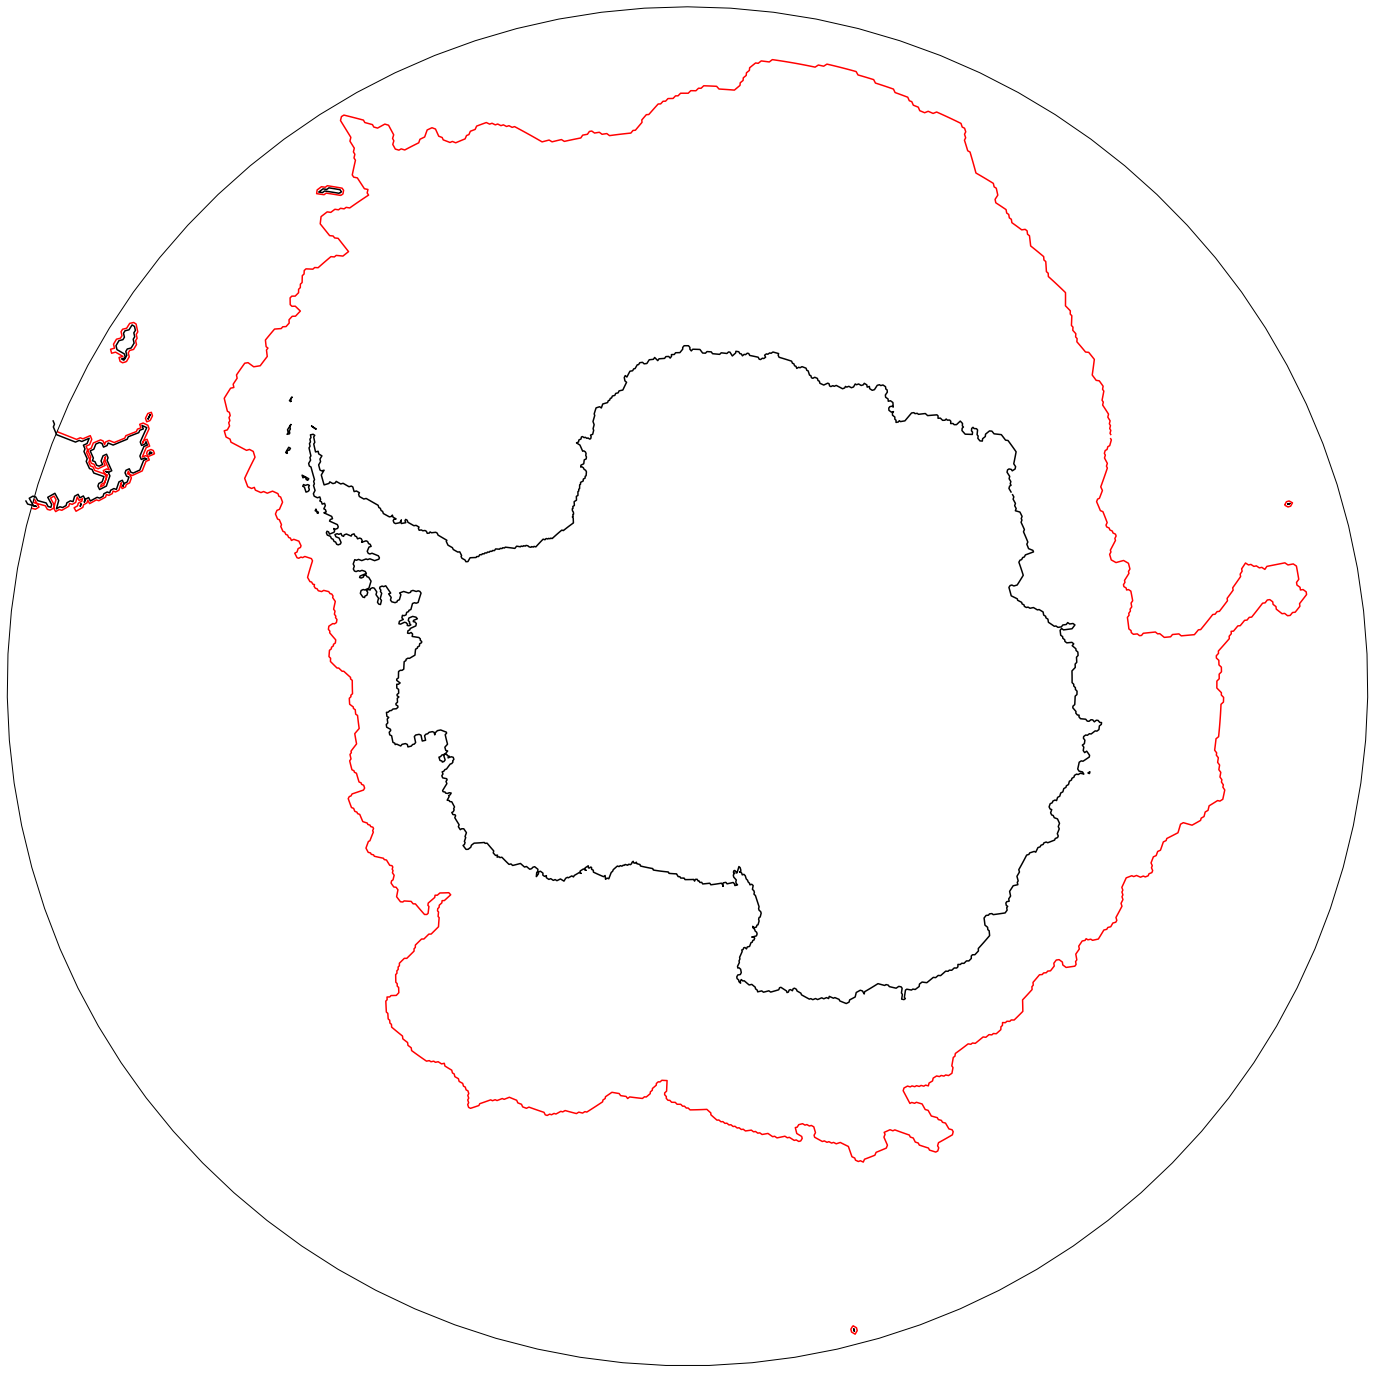

In [208]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50, grid = False)
# basic contour - no attempt at isolating a continuous circumpolar feature
ax.contour(xh, yh,temp_mask, levels = [0,1], colors = ['r'], alpha = 1, transform = ccrs.PlateCarree())
# # circumpolar continuous isobath
# ax.contour(xh, yh,contour_mask, levels = [0,1], colors = ['b'], alpha = 1, transform = ccrs.PlateCarree())
plt.show()

In [6]:
slope_data = np.load('/work/Ruth.Moorman/Bathymetry/ACCESSOM201_shelf_mask.npz')
shelf_mask = slope_data['contour_masked_above']
yt_ocean = slope_data['yt_ocean']
xt_ocean = slope_data['xt_ocean']
mask_y_transport = slope_data['mask_y_transport']
mask_x_transport = slope_data['mask_x_transport']
mask_y_transport_numbered = slope_data['mask_y_transport_numbered']
mask_x_transport_numbered = slope_data['mask_x_transport_numbered']
mask_y_transport = xr.DataArray(mask_y_transport, coords=[yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'])
mask_x_transport = xr.DataArray(mask_x_transport, coords=[yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords=[yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords=[yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'])
latslice = slice(-80.02, -59)
mask_y_transport = mask_y_transport.sel(yt_ocean =latslice)
mask_x_transport = mask_x_transport.sel(yt_ocean = latslice)
mask_y_transport_numbered = mask_y_transport_numbered.sel(yt_ocean = latslice)
mask_x_transport_numbered = mask_x_transport_numbered.sel(yt_ocean = latslice)

In [7]:
mask_x_numbered_1d = mask_x_transport_numbered.stack(isobath_index = ['yt_ocean', 'xt_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(isobath_index = ['yt_ocean', 'xt_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
isobath_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'isobath_index')
isobath_ordering = isobath_ordering.sortby(isobath_ordering)

In [8]:
mask_x_numbered_1d = mask_x_numbered_1d.sortby(mask_x_numbered_1d)
mask_y_numbered_1d = mask_y_numbered_1d.sortby(mask_y_numbered_1d)

In [9]:
mask_y_numbered_1d

<xarray.DataArray (isobath_index: 3966)>
array([1.000e+00, 2.000e+00, 3.000e+00, ..., 5.999e+03, 6.000e+03,
       6.001e+03], dtype=float32)
Coordinates:
  * isobath_index  (isobath_index) MultiIndex
  - yt_ocean       (isobath_index) float64 -66.03 -66.03 ... -66.07 -66.07
  - xt_ocean       (isobath_index) float64 -279.9 -279.8 -279.7 ... 79.85 79.95

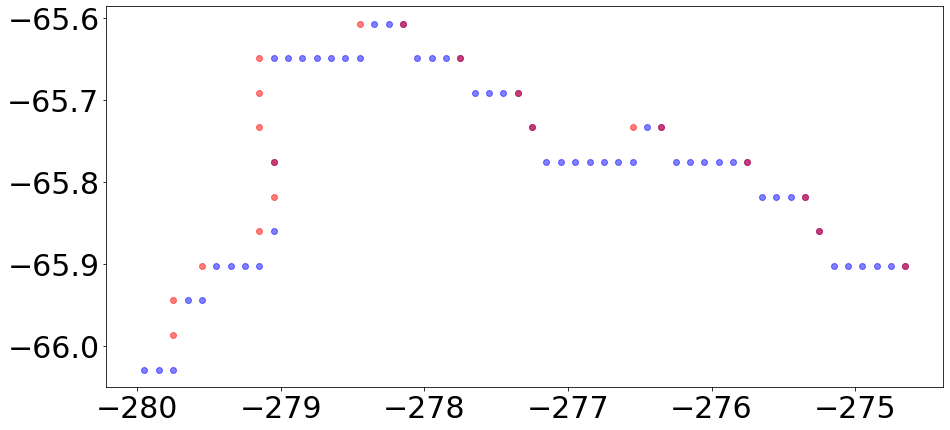

In [11]:
plt.figure(figsize = (15,7))
ax = plt.subplot()
ax.plot(mask_y_numbered_1d.xt_ocean[:56], mask_y_numbered_1d.yt_ocean[:56], 'bo', alpha = 0.5)
ax.plot(mask_x_numbered_1d.xt_ocean[:20], mask_x_numbered_1d.yt_ocean[:20], 'ro', alpha = 0.5)
plt.show()

## Need 1000m isobath for p5, p25, p125 runs

In [84]:
#static
expdir = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/'
static_25 = xr.open_dataset(expdir+'/cycle1/ocean_static/20170101.ocean_static.nc')
#
static_5 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle1/gfdl.ncrc4-intel16f2-prod/pp/ocean_monthly/ocean_monthly.static.nc')
bathy_5 = static_5.deptho.load()
#
exp_dir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle1/gfdl.ncrc4-intel16-prod/pp'
static_125 = xr.open_dataset(exp_dir+'/ocean_daily/ocean_daily.static.nc')

In [17]:
def so_basics(ax,land_mask,geolon, geolat, lat_north = -29, grid = True):
    latslice = slice(-90,lat_north)
    ax.contour(geolon.sel(yh = latslice), geolat.sel(yh = latslice),land_mask.sel(yh = latslice),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

In [70]:
def OM4_Antarctic_bathymetry_contour(static, contour_depth, lat_north = -29):
    bathy = static.deptho.sel(yh = slice(-90,lat_north))
    land_mask = static.wet.sel(yh = slice(-90,lat_north))
    geolon = static.geolon.sel(yh = slice(-90,lat_north))
    geolat = static.geolat.sel(yh = slice(-90,lat_north))

    # initial basic bathymetry masking
    temp_mask = bathy.copy().fillna(1)
    xh = temp_mask.xh
    yh = temp_mask.yh
    temp_mask = temp_mask.where(temp_mask <= contour_depth) * 0 + 1
    temp_mask = temp_mask.fillna(0)
    temp_mask = temp_mask.values # extract numpy file
    # # this spreads the isobath contour so all points are connected adjacently (not just 
    # # diagonally):
    kernel = np.ones((3,3),np.uint8)
    contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
    # start at western edge of domain, at y point closest to correct depth contour:
    contour_mask = np.zeros_like(land_mask.values) 
    contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][-1]
    contour_mask[contour_lat_index_start,0] = 1
    # loop through to find adjacent point closest to contour depth (not inc previous point):
    last_index_i = 0
    last_index_j = contour_lat_index_start
    count = 0
    while last_index_i<(len(xh)-1): # 1440 is xh dimension length
        # first time don't go backwards:
        if last_index_i == 0:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                0,
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
        else:
            points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                contour_mask0[last_index_j,last_index_i-1],
                contour_mask0[last_index_j+1,last_index_i],
                contour_mask0[last_index_j-1,last_index_i]])
        new_loc = np.where(points_to_compare==1)[0]
        # this gives each point along contour a unique index number:
        if len(new_loc)==0:
            contour_mask[last_index_j,last_index_i] = 0
            contour_mask0[last_index_j,last_index_i] = 0
            #contour_mask0[contour_mask==count] = 0
            #print('j'+str(last_index_j)+'i'+str(last_index_i))
            count = count - 1
            last_index_i = np.where(contour_mask==count+1)[1]
            last_index_j = np.where(contour_mask==count+1)[0]
            continue
        elif len(new_loc)>0:
            if new_loc[0] == 0:
                new_index_i = last_index_i+1
                new_index_j = last_index_j
            elif new_loc[0] == 1:
                new_index_i = last_index_i-1
                new_index_j = last_index_j
            elif new_loc[0] == 2:
                new_index_i = last_index_i
                new_index_j = last_index_j+1
            elif new_loc[0] == 3:
                new_index_i = last_index_i
                new_index_j = last_index_j-1
            contour_mask[new_index_j,new_index_i] = count + 2
            contour_mask0[last_index_j,last_index_i] = 2
            last_index_j = new_index_j
            last_index_i = new_index_i
            count += 1
#     # cut out a pesky enclosed loop off the Antarctic Peninsula
#     contour_mask = np.where(np.logical_and(np.greater_equal(contour_mask,1620),np.less_equal(contour_mask,1664)), 0,contour_mask)
#     contour_mask[contour_mask>1664] -= 45
#     # there's another enclosed section of the contour in the ross sea
#     a = np.copy(contour_mask)
#     a[a>760] +=1
#     a[93,477] = 761
#     a = np.where(np.logical_and(np.greater_equal(a,728),np.less_equal(a,760)), 0,a)
#     a[a>760] -= 33
#     contour_mask = a
    # this is the sequentially numbered isobath, it provides an along isobath index
    contour_mask_numbered = contour_mask
    # fill in points to north of contour:
    contour_masked_above = np.copy(contour_mask_numbered)
    contour_masked_above[-1,0] = -100
    # from top left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj-1,ii+1] == 0:
                    contour_masked_above[jj-1,ii+1] = -100
    # from top right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh))[::-1][:-1]:
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj-1,ii] == 0:
                    contour_masked_above[jj-1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj-1,ii-1] == 0:
                    contour_masked_above[jj-1,ii-1] = -100
    # from bottom right:
    for ii in range(len(xh))[::-1][:-1]:
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii-1] == 0:
                    contour_masked_above[jj,ii-1] = -100
                if contour_masked_above[jj+1,ii-1] == 0:
                    contour_masked_above[jj+1,ii-1] = -100
    # from bottom left:
    for ii in range(len(xh)-1):
        for jj in range(len(yh)-1):
            if contour_masked_above[jj,ii] == -100:
                if contour_masked_above[jj+1,ii] == 0:
                    contour_masked_above[jj+1,ii] = -100
                if contour_masked_above[jj,ii+1] == 0:
                    contour_masked_above[jj,ii+1] = -100
                if contour_masked_above[jj+1,ii+1] == 0:
                    contour_masked_above[jj+1,ii+1] = -100
    ############################
    # separate out points on isobath that will correspond to zonal or meridional transport
    # across contour (i.e. depending on localshape of contour):

    # make masks to multiply x and y transports at correct places:
    mask_x_transport = np.zeros_like(contour_mask_numbered)
    mask_y_transport = np.zeros_like(contour_mask_numbered)
    mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
    mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)
    # make halos:
    contour_masked_above_halo = np.zeros((contour_masked_above.shape[0],
        contour_masked_above.shape[1]+2))
    contour_masked_above_halo[:,0] = contour_masked_above[:,-1]
    contour_masked_above_halo[:,1:-1] = contour_masked_above
    contour_masked_above_halo[:,-1] = contour_masked_above[:,0]

    new_number_count = 1
    for mask_loc in range(1,int(np.max(contour_mask_numbered))+1):
        index_i = np.where(contour_mask_numbered==mask_loc)[1]
        index_j = np.where(contour_mask_numbered==mask_loc)[0]
        # if point above is towards Antarctica and point below is away from Antarctica:
        # take transport grid point to north of t grid:
        if (contour_masked_above[index_j+1,index_i]==0) and \
            (contour_masked_above[index_j-1,index_i]!=0):
            mask_y_transport[index_j,index_i] = -1
            # important to do 
            mask_y_transport_numbered[index_j,index_i] = new_number_count
            new_number_count += 1
        # if point below is towards Antarctica and point above is away from Antarctica:
        # take transport grid point to south of t grid:
        elif (contour_masked_above[index_j-1,index_i]==0) and \
            (contour_masked_above[index_j+1,index_i]!=0):
            mask_y_transport[index_j-1,index_i] = 1
            mask_y_transport_numbered[index_j-1,index_i] = new_number_count
            new_number_count += 1
        # if point to right is towards Antarctica and point to left is away from Antarctica:
        # zonal indices increased by 1 due to halos
        # take transport grid point on right of t grid:
        if (contour_masked_above_halo[index_j,index_i+2]==0) and \
            (contour_masked_above_halo[index_j,index_i]!=0):
            mask_x_transport[index_j,index_i] = -1
            mask_x_transport_numbered[index_j,index_i] = new_number_count
            new_number_count += 1
        # if point to left is towards Antarctica and point to right is away from Antarctica:
        # take transport grid point on left of t grid:
        elif (contour_masked_above_halo[index_j,index_i]==0) and \
            (contour_masked_above_halo[index_j,index_i+2]!=0):
            mask_x_transport[index_j,index_i-1] = 1
            mask_x_transport_numbered[index_j,index_i-1] = new_number_count
            new_number_count += 1
        # save as xarray dataset
    
    contour_mask_numbered = xr.DataArray(contour_mask_numbered, coords = [yh, xh], dims = ['yh', 'xh'])
    contour_mask_numbered.attrs['description'] = '(OM4) Continous circumpolar approximation of the near Antarctic 2000 m isobath. Points on the isobath (tracer points) are numbered sequentially, providing an along-isobath index.'
    contour_masked_south = xr.DataArray(contour_masked_above, coords = [yh, xh], dims = ['yh', 'xh'])
    contour_masked_south = contour_masked_south.where(contour_masked_south >= 0) * 0 + 1 
    contour_masked_south.attrs['description'] = '(OM4) Masks for the region south of a continous circumpolar approximation of the near Antarctic 2000 m isobath. Tracer points on and polewards of the isobath are 1, points equatorward of the isobath are nan.'
    mask_y_transport = xr.DataArray(mask_y_transport, coords = [yh,xh], dims = ['yh','xh'])
    mask_y_transport.attrs['description'] = '(OM4) Informs which sign of v (meridional transport) is transport *into* the 2000 m isobath enclosed region. This mask is -1 where positive v denotes transport poleward across the isobath and +1 where positive v denotes tranport equatorward across the isobath. 0 where isobath not present, or cross isobath transport is zonal (see mask_x_transport). When using this mask, positive cross-isobath transports are offshore.'
    mask_x_transport = xr.DataArray(mask_x_transport, coords = [yh,xh], dims = ['yh','xh'])
    mask_x_transport.attrs['description'] = '(OM4) Informs which sign of u (zonal transport) is transport *into* the 2000 m isobath enclosed region. This mask is -1 where positive u denotes transport poleward across the isobath and +1 where positive u denotes tranport equatorward across the isobath. 0 where isobath not present, or cross isobath transport is meridional (see mask_y_transport). When using this mask, positive cross-isobath transports are offshore.'
    mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yh,xh], dims = ['yh','xh'])
    mask_y_transport_numbered.attrs['description'] = '(OM4) as contour_mask_numbered, except only points on the isobath running east-west (for which cross-isobath transport is meridional transport) included.'
    mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yh,xh], dims = ['yh','xh'])
    mask_x_transport_numbered.attrs['description'] = '(OM4) as contour_mask_numbered, except only points on the isobath running north-south (for which cross-isobath transport is zonal transport) included.'
    
    contour_mask_numbered.coords['geolon'] = geolon
    contour_mask_numbered.coords['geolat'] = geolat
    contour_masked_south.coords['geolon'] = geolon
    contour_masked_south.coords['geolat'] = geolat
    mask_y_transport.coords['geolon'] = geolon
    mask_y_transport.coords['geolat'] = geolat
    mask_x_transport.coords['geolon'] = geolon
    mask_x_transport.coords['geolat'] = geolat
    mask_y_transport_numbered.coords['geolon'] = geolon
    mask_y_transport_numbered.coords['geolat'] = geolat
    mask_x_transport_numbered.coords['geolon'] = geolon
    mask_x_transport_numbered.coords['geolat'] = geolat
    return contour_mask_numbered, contour_masked_south, mask_y_transport, mask_x_transport, mask_y_transport_numbered, mask_x_transport_numbered 

In [93]:
contour_mask_numbered, contour_masked_south, mask_y_transport, mask_x_transport, mask_y_transport_numbered, mask_x_transport_numbered  = OM4_Antarctic_bathymetry_contour(static_5, contour_depth=1000, lat_north = -29)

In [94]:
land_mask_5 = static_5.wet.sel(yh = slice(-90,-29)).load()
geolon_5 = static_5.geolon.sel(yh = slice(-90,-29)).load()
geolat_5 = static_5.geolat.sel(yh = slice(-90,-29)).load()
land_mask_u_5 = static_5.wet_u.sel(yh = slice(-90,-29)).load()
geolon_u_5 = static_5.geolon_u.sel(yh = slice(-90,-29)).load()
geolat_u_5 = static_5.geolat_u.sel(yh = slice(-90,-29)).load()

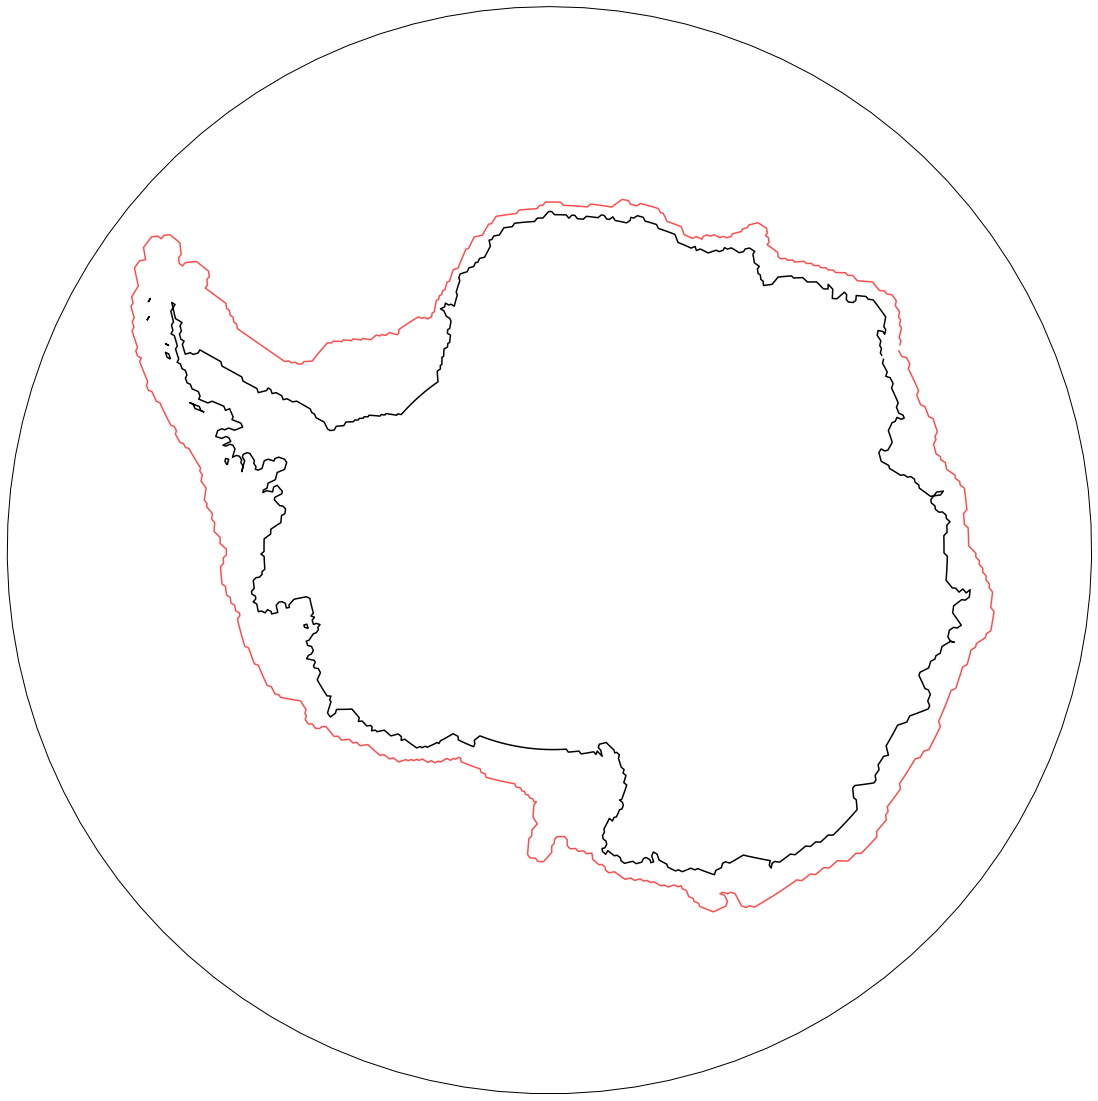

In [95]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
so_basics(ax,land_mask_5,geolon_5, geolat_5, lat_north = -58, grid = False)
# so_basics(ax,land_mask_u_25,geolon_u_25, geolat_u_25, lat_north = -58, grid = False)
ax.contour(contour_masked_south.geolon, contour_masked_south.geolat,contour_masked_south.fillna(0), levels = [0,1], colors = ['r'], alpha = 0.7, transform = ccrs.PlateCarree())

plt.show()

In [96]:
ds = xr.Dataset({'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south, 'mask_y_transport':mask_y_transport, 'mask_x_transport':mask_x_transport, 'mask_y_transport_numbered':mask_y_transport_numbered, 'mask_x_transport_numbered':mask_x_transport_numbered})

In [97]:
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/OM4p5_Antarctic_1000m_isobath.nc')

In [101]:
xq = geolat_u_5.xq.values

In [102]:
contour_mask_numbered.coords['xh'] = xq
contour_masked_south.coords['xh'] = xq
mask_y_transport.coords['xh'] = xq
mask_x_transport.coords['xh'] = xq
mask_y_transport_numbered.coords['xh'] = xq
mask_x_transport_numbered.coords['xh'] = xq
contour_mask_numbered = contour_mask_numbered.rename({'xh':'xq'})
contour_masked_south = contour_masked_south.rename({'xh':'xq'})
mask_y_transport = mask_y_transport.rename({'xh':'xq'})
mask_x_transport = mask_x_transport.rename({'xh':'xq'})
mask_y_transport_numbered = mask_y_transport_numbered.rename({'xh':'xq'})
mask_x_transport_numbered = mask_x_transport_numbered.rename({'xh':'xq'})
contour_mask_numbered.coords['geolon'] = geolon_u_5
contour_masked_south.coords['geolon'] = geolon_u_5
mask_y_transport.coords['geolon'] = geolon_u_5
mask_x_transport.coords['geolon'] = geolon_u_5
mask_y_transport_numbered.coords['geolon'] = geolon_u_5
mask_x_transport_numbered.coords['geolon'] = geolon_u_5
contour_mask_numbered.coords['geolat'] = geolat_u_5
contour_masked_south.coords['geolat'] = geolat_u_5
mask_y_transport.coords['geolat'] = geolat_u_5
mask_x_transport.coords['geolat'] = geolat_u_5
mask_y_transport_numbered.coords['geolat'] = geolat_u_5
mask_x_transport_numbered.coords['geolat'] = geolat_u_5

In [103]:
ds = xr.Dataset({'contour_mask_numbered':contour_mask_numbered, 'contour_masked_south':contour_masked_south, 'mask_y_transport':mask_y_transport, 'mask_x_transport':mask_x_transport, 'mask_y_transport_numbered':mask_y_transport_numbered, 'mask_x_transport_numbered':mask_x_transport_numbered})

In [104]:
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/OM4p5_Antarctic_1000m_isobath_u.nc')